In [1]:
# TODO change network to use only one channel input to neural network

# VinBigData detectron2 train


This competition is object detaction task to find a class and location of thoracic abnormalities from chest x-ray image (radiographs).

`detectron2` is one of the famous pytorch object detection library, I will introduce how to use this library to train models provided by this library with this competition's data!

 - https://github.com/facebookresearch/detectron2

> Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron, and it originates from maskrcnn-benchmark.
![](https://user-images.githubusercontent.com/1381301/66535560-d3422200-eace-11e9-9123-5535d469db19.png)


[UPDATE 2021/1/11] I published prediction kernel, please check https://www.kaggle.com/corochann/vinbigdata-detectron2-prediction too!

[UPDATE 2021/1/24] I added more advanced usage to customize <code>detectron2</code>, especially:

 - How to define & use `mapper` to add your customized augmentation.
 - Use validation data during training.
 - Define `Evaluator` and calculating competition metric, AP40.
 - Define `Hook` to calculate validation loss & plotting training/validation loss curve.

<div style="color:red">
    [UPDATE 2021/2/18] Added links to relevant useful discussions in "Next step" topic.</div>

# Table of Contents

** [Dataset preparation](#dataset)** <br/>
** [Installation](#installation)** <br/>
** [Training method implementations](#train_method)** <br/>
** [Customizing detectron2 trainer](#custom_trainer) ** [Advanced topic, skip it first time] <br/>
**   - [Mapper for augmentation](#mapper)** <br/>
**   - [Evaluator](#evaluator)** <br/>
**   - [Loss evaluation hook](#loss_hook)** <br/>
** [Loading Data](#load_data)** <br/>
** [Data Visualization](#data_vis)** <br/>
** [Training](#training)** <br/>
** [Visualize loss curve & competition metric AP40](#vis_loss)** <br/>
** [Visualization of augmentation by Mapper](#vis_aug)** <br/>
** [Next step](#next_step)** <br/>

<a id="dataset"></a>
# Dataset preparation

Preprocessing x-ray image format (dicom) into normal png image format is already done by @xhlulu in the below discussion:
 - [Multiple preprocessed datasets: 256/512/1024px, PNG and JPG, modified and original ratio](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/207955).

Here I will just use the dataset [VinBigData Chest X-ray Resized PNG (256x256)](https://www.kaggle.com/xhlulu/vinbigdata-chest-xray-resized-png-256x256) to skip the preprocessing and focus on modeling part.

I also uploaded the original sized png images:
 - [vinbigdata-chest-xray-original-png](https://www.kaggle.com/corochann/vinbigdata-chest-xray-original-png) ([notebook](https://www.kaggle.com/corochann/preprocessing-image-original-size-lossless-png) on kaggle fails due to disk limit)

Please upvote the dataset as well!

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm #progress bar
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns #statistical data visualization

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)


<a id="installation"></a>
# Installation

detectron2 is not pre-installed in this kaggle docker, so let's install it. 
We can follow [installation instruction](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md), we need to know CUDA and pytorch version to install correct `detectron2`.

In [3]:
!nvidia-smi

Sat Jun 12 13:10:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX150       Off  | 00000000:02:00.0 Off |                  N/A |
| N/A   81C    P0    N/A /  N/A |    335MiB /  2002MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [5]:
import torch

torch.__version__

'1.7.1'

It seems CUDA=10.2 and torch==1.7.0 is used in this kaggle docker image.

See [installation](https://detectron2.readthedocs.io/tutorials/install.html) for details.

In [6]:
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

<a id="train_method"></a>
# Training method implementations

Basically we don't need to implement neural network part, `detectron2` already implements famous architectures and provides its pre-trained weights. We can finetune these pre-trained architectures.

These models are summarized in [MODEL_ZOO.md](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

In this competition, we need object detection model, I will choose [R50-FPN](https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml) for this kernel.

## Data preparation

`detectron2` provides high-level API for training custom dataset.

To define custom dataset, we need to create **list of dict** (`dataset_dicts`) where each dict contains following:

 - file_name: file name of the image.
 - image_id: id of the image, index is used here.
 - height: height of the image.
 - width: width of the image.
 - annotation: This is the ground truth annotation data for object detection, which contains following
     - bbox: bounding box pixel location with shape (n_boxes, 4)
     - bbox_mode: `BoxMode.XYXY_ABS` is used here, meaning that absolute value of (xmin, ymin, xmax, ymax) annotation is used in the `bbox`.
     - category_id: class label id for each bounding box, with shape (n_boxes,)

`get_vinbigdata_dicts` is for train dataset preparation and `get_vinbigdata_dicts_test` is for test dataset preparation.

This `dataset_dicts` contains the metadata for actual data fed into the neural network.<br/>
It is loaded beforehand of the training **on memory**, so it should contain all the metadata (image filepath etc) to construct training dataset, but **should not contain heavy data**.<br/>

In practice, loading all the taining image arrays are too heavy to be loaded on memory, so these are loaded inside `DataLoader` on-demand (This is done by mapper class in `detectron2`, as I will explain later).

In [7]:
import pickle # Python object serialization
from pathlib import Path
from typing import Optional

import cv2
import numpy as np
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm


def get_vinbigdata_dicts(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_indices: Optional[np.ndarray] = None,
    use_class14: bool = False,
):
    # name the dataset dictionary *.pkl file
    debug_str = f"_debug{int(debug)}" #formatted string: _debug1
    train_data_type_str = f"_{train_data_type}"
    class14_str = f"_14class{int(use_class14)}"
    cache_path = Path(".") / f"dataset_dicts_cache{train_data_type_str}{class14_str}{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug... select only 500 records

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):#iterate with estimated progress
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train_df.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    if use_class14:
                        # Use this No finding class with the bbox covering all image area.
                        bbox_resized = [0, 0, resized_width, resized_height]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    else:
                        # This annotator does not find anything, skip.
                        pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        float(row["x_min"]) * w_ratio,
                        float(row["y_min"]) * h_ratio,
                        float(row["x_max"]) * w_ratio,
                        float(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            # record["image_id"] = index
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


In [8]:
# --- utils ---
from pathlib import Path
from typing import Any, Union

import yaml


def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath: Union[str, Path]) -> Any:
    with open(filepath, "r") as f:
        content = yaml.full_load(f)
    return content


In [9]:
# --- configs ---
thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}


<a id="custom_trainer"></a>
# Customizing detectron2 trainer

※ This section is advanced, I recommend to jump to **Training scripts** section for the first time of reading.

You can refer the [Detectron2 Beginner's Tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=QHnVupBBn9eR) Colab Notebook (or [version 7 of this kernel](https://www.kaggle.com/corochann/vinbigdata-detectron2-train?scriptVersionId=51628272)) for the simple usage of detectron2 how to train custom dataset. `DefaultTrainer` is used in the example which provides the starting point to train your model with custom dataset.

It is nice to start with, however I want to customize the training behavior more to improve the model's performance.
We can make own Trainer class (`MyTrainer` here) for this purpose, and override methods to provide customized behavior.

<a id="mapper"></a>
## Mapper for augmentation

`Mapper` class is used inside pytorch `DataLoader`. It is responsible for converting `dataset_dicts` into actual data fed into the neural network, and we can insert augmentation process in this Mapper class.

 - Ref: [detectron2 docs "Dataloader"](https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html)

I implemented `MyMapper` which uses augmentations implemented in `detectron2`, and `AlbumentationsMapper` which uses albumentations library augmentations.<br/> 
I will demonstrate these augmentations later, so you can skip reading the code and please just jump to next.

In [10]:
"""
Referenced:
 - https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html
 - https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data
"""
import copy
import logging

import detectron2.data.transforms as T
import torch
from detectron2.data import detection_utils as utils


class MyMapper:
    """Mapper which uses `detectron2.data.transforms` augmentations"""

    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = [
            # T.Resize((800, 800)),
        ]
        if is_train:
            aug_list.extend([getattr(T, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.augmentations = T.AugmentationList(aug_list)
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[MyDatasetMapper] Augmentations used in {mode}: {self.augmentations}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        aug_input = T.AugInput(image)
        transforms = self.augmentations(aug_input)
        image = aug_input.image

        # if not self.is_train:
        #     # USER: Modify this if you want to keep them for some reason.
        #     dataset_dict.pop("annotations", None)
        #     dataset_dict.pop("sem_seg_file_name", None)
        #     return dataset_dict

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        annos = [
            utils.transform_instance_annotations(obj, transforms, image_shape)
            for obj in dataset_dict.pop("annotations")
            if obj.get("iscrowd", 0) == 0
        ]
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [11]:
"""
Referenced:
 - https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html
 - https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data
"""
import albumentations as A
import copy
import numpy as np

import torch
from detectron2.data import detection_utils as utils


class AlbumentationsMapper:
    """Mapper which uses `albumentations` augmentations"""
    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = [
#             A.augmentations.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.3, always_apply=False, p=0.7),
#             A.augmentations.geometric.rotate.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.2)
        ]
        if is_train:
            aug_list.extend([getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.transform = A.Compose(
            aug_list, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category_ids"])
        )
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[AlbumentationsMapper] Augmentations used in {mode}: {self.transform}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        # aug_input = T.AugInput(image)
        # transforms = self.augmentations(aug_input)
        # image = aug_input.image

        prev_anno = dataset_dict["annotations"]
        bboxes = np.array([obj["bbox"] for obj in prev_anno], dtype=np.float32)
        # category_id = np.array([obj["category_id"] for obj in dataset_dict["annotations"]], dtype=np.int64)
        category_id = np.arange(len(dataset_dict["annotations"]))

        transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_id)
        image = transformed["image"]
        annos = []
        for i, j in enumerate(transformed["category_ids"]):
            d = prev_anno[j]
            d["bbox"] = transformed["bboxes"][i]
            annos.append(d)
        dataset_dict.pop("annotations", None)  # Remove unnecessary field.

        # if not self.is_train:
        #     # USER: Modify this if you want to keep them for some reason.
        #     dataset_dict.pop("annotations", None)
        #     dataset_dict.pop("sem_seg_file_name", None)
        #     return dataset_dict

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict


<a id="evaluator"></a>
## Evaluator

To evaluate validation dataset to calculate competition metric, we need `Evaluator`.

Famouns dataset's evaluator is already implemented in `detectron2`. <br/>
For example, many kinds of AP (Average Precision) is calculted in `COCOEvaluator`.<br/>
`COCOEvaluator` only calculates AP with IoU from 0.50 to 0.95, but we need AP with IoU 0.40.

Here, I modified `COCOEvaluator` implementation to calculate AP with IoU 0.40 and replaced to show this value instead of AP with IoU 0.70.

In [12]:
"""
Original code from https://github.com/cocodataset/cocoapi/blob/8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9/PythonAPI/pycocotools/cocoeval.py
Just modified to show AP@40
"""
# Copyright (c) Facebook, Inc. and its affiliates.
import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tabulate import tabulate

import detectron2.utils.comm as comm
from detectron2.config import CfgNode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.evaluation.fast_eval_api import COCOeval_opt
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import create_small_table


def vin_summarize(self):
    '''
    Compute and display summary metrics for evaluation results.
    Note this functin can *only* be applied on the default parameter setting
    '''

    def _summarize(ap=1, iouThr=None, areaRng='all', maxDets=100):
        p = self.params
        iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
        titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
        typeStr = '(AP)' if ap == 1 else '(AR)'
        iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
            if iouThr is None else '{:0.2f}'.format(iouThr)

        aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
        mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
        if ap == 1:
            # dimension of precision: [TxRxKxAxM]
            s = self.eval['precision']
            # IoU
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, :, aind, mind]
        else:
            # dimension of recall: [TxKxAxM]
            s = self.eval['recall']
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, aind, mind]
        if len(s[s > -1]) == 0:
            mean_s = -1
        else:
            mean_s = np.mean(s[s > -1])
        print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
        return mean_s

    def _summarizeDets():
        stats = np.zeros((12,))
        stats[0] = _summarize(1)
        stats[1] = _summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
        # stats[2] = _summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
        stats[2] = _summarize(1, iouThr=.4, maxDets=self.params.maxDets[2])
        stats[3] = _summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
        stats[4] = _summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[5] = _summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
        stats[6] = _summarize(0, maxDets=self.params.maxDets[0])
        stats[7] = _summarize(0, maxDets=self.params.maxDets[1])
        stats[8] = _summarize(0, maxDets=self.params.maxDets[2])
        stats[9] = _summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
        stats[10] = _summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[11] = _summarize(0, areaRng='large', maxDets=self.params.maxDets[2])
        return stats

    def _summarizeKps():
        stats = np.zeros((10,))
        stats[0] = _summarize(1, maxDets=20)
        stats[1] = _summarize(1, maxDets=20, iouThr=.5)
        stats[2] = _summarize(1, maxDets=20, iouThr=.75)
        stats[3] = _summarize(1, maxDets=20, areaRng='medium')
        stats[4] = _summarize(1, maxDets=20, areaRng='large')
        stats[5] = _summarize(0, maxDets=20)
        stats[6] = _summarize(0, maxDets=20, iouThr=.5)
        stats[7] = _summarize(0, maxDets=20, iouThr=.75)
        stats[8] = _summarize(0, maxDets=20, areaRng='medium')
        stats[9] = _summarize(0, maxDets=20, areaRng='large')
        return stats

    if not self.eval:
        raise Exception('Please run accumulate() first')
    iouType = self.params.iouType
    if iouType == 'segm' or iouType == 'bbox':
        summarize = _summarizeDets
    elif iouType == 'keypoints':
        summarize = _summarizeKps
    self.stats = summarize()


print("HACKING: overriding COCOeval.summarize = vin_summarize...")
COCOeval.summarize = vin_summarize


class VinbigdataEvaluator(DatasetEvaluator):
    """
    Evaluate AR for object proposals, AP for instance detection/segmentation, AP
    for keypoint detection outputs using COCO's metrics.
    See http://cocodataset.org/#detection-eval and
    http://cocodataset.org/#keypoints-eval to understand its metrics.

    In addition to COCO, this evaluator is able to support any bounding box detection,
    instance segmentation, or keypoint detection dataset.
    """

    def __init__(
        self,
        dataset_name,
        tasks=None,
        distributed=True,
        output_dir=None,
        *,
        use_fast_impl=True,
        kpt_oks_sigmas=(),
    ):
        """
        Args:
            dataset_name (str): name of the dataset to be evaluated.
                It must have either the following corresponding metadata:

                    "json_file": the path to the COCO format annotation

                Or it must be in detectron2's standard dataset format
                so it can be converted to COCO format automatically.
            tasks (tuple[str]): tasks that can be evaluated under the given
                configuration. A task is one of "bbox", "segm", "keypoints".
                By default, will infer this automatically from predictions.
            distributed (True): if True, will collect results from all ranks and run evaluation
                in the main process.
                Otherwise, will only evaluate the results in the current process.
            output_dir (str): optional, an output directory to dump all
                results predicted on the dataset. The dump contains two files:

                1. "instances_predictions.pth" a file in torch serialization
                   format that contains all the raw original predictions.
                2. "coco_instances_results.json" a json file in COCO's result
                   format.
            use_fast_impl (bool): use a fast but **unofficial** implementation to compute AP.
                Although the results should be very close to the official implementation in COCO
                API, it is still recommended to compute results with the official API for use in
                papers. The faster implementation also uses more RAM.
            kpt_oks_sigmas (list[float]): The sigmas used to calculate keypoint OKS.
                See http://cocodataset.org/#keypoints-eval
                When empty, it will use the defaults in COCO.
                Otherwise it should be the same length as ROI_KEYPOINT_HEAD.NUM_KEYPOINTS.
        """
        self._logger = logging.getLogger(__name__)
        self._distributed = distributed
        self._output_dir = output_dir
        self._use_fast_impl = use_fast_impl

        if tasks is not None and isinstance(tasks, CfgNode):
            kpt_oks_sigmas = (
                taMODELsks.TEST.KEYPOINT_OKS_SIGMAS if not kpt_oks_sigmas else kpt_oks_sigmas
            )
            self._logger.warn(
                "COCO Evaluator instantiated using config, this is deprecated behavior."
                " Please pass in explicit arguments instead."
            )
            self._tasks = None  # Infering it from predictions should be better
        else:
            self._tasks = tasks

        self._cpu_device = torch.device("cpu")

        self._metadata = MetadataCatalog.get(dataset_name)
        if not hasattr(self._metadata, "json_file"):
            self._logger.info(
                f"'{dataset_name}' is not registered by `register_coco_instances`."
                " Therefore trying to convert it to COCO format ..."
            )

            cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
            self._metadata.json_file = cache_path
            convert_to_coco_json(dataset_name, cache_path)

        json_file = PathManager.get_local_path(self._metadata.json_file)
        with contextlib.redirect_stdout(io.StringIO()):
            self._coco_api = COCO(json_file)

        # Test set json files do not contain annotations (evaluation must be
        # performed using the COCO evaluation server).
        self._do_evaluation = "annotations" in self._coco_api.dataset
        if self._do_evaluation:
            self._kpt_oks_sigmas = kpt_oks_sigmas

    def reset(self):
        self._predictions = []

    def process(self, inputs, outputs):
        """
        Args:
            inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
                It is a list of dict. Each dict corresponds to an image and
                contains keys like "height", "width", "file_name", "image_id".
            outputs: the outputs of a COCO model. It is a list of dicts with key
                "instances" that contains :class:`Instances`.
        """
        for input, output in zip(inputs, outputs):
            prediction = {"image_id": input["image_id"]}

            if "instances" in output:
                instances = output["instances"].to(self._cpu_device)
                prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
            if "proposals" in output:
                prediction["proposals"] = output["proposals"].to(self._cpu_device)
            if len(prediction) > 1:
                self._predictions.append(prediction)

    def evaluate(self, img_ids=None):
        """
        Args:
            img_ids: a list of image IDs to evaluate on. Default to None for the whole dataset
        """
        if self._distributed:
            comm.synchronize()
            predictions = comm.gather(self._predictions, dst=0)
            predictions = list(itertools.chain(*predictions))

            if not comm.is_main_process():
                return {}
        else:
            predictions = self._predictions

        if len(predictions) == 0:
            self._logger.warning("[VinbigdataEvaluator] Did not receive valid predictions.")
            return {}

        if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(predictions, f)

        self._results = OrderedDict()
        if "proposals" in predictions[0]:
            self._eval_box_proposals(predictions)
        if "instances" in predictions[0]:
            self._eval_predictions(predictions, img_ids=img_ids)
        # Copy so the caller can do whatever with results
        return copy.deepcopy(self._results)

    def _tasks_from_predictions(self, predictions):
        """
        Get COCO API "tasks" (i.e. iou_type) from COCO-format predictions.
        """
        tasks = {"bbox"}
        for pred in predictions:
            if "segmentation" in pred:
                tasks.add("segm")
            if "keypoints" in pred:
                tasks.add("keypoints")
        return sorted(tasks)

    def _eval_predictions(self, predictions, img_ids=None):
        """
        Evaluate predictions. Fill self._results with the metrics of the tasks.
        """
        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
        tasks = self._tasks or self._tasks_from_predictions(coco_results)

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            dataset_id_to_contiguous_id = self._metadata.thing_dataset_id_to_contiguous_id
            all_contiguous_ids = list(dataset_id_to_contiguous_id.values())
            num_classes = len(all_contiguous_ids)
            assert min(all_contiguous_ids) == 0 and max(all_contiguous_ids) == num_classes - 1

            reverse_id_mapping = {v: k for k, v in dataset_id_to_contiguous_id.items()}
            for result in coco_results:
                category_id = result["category_id"]
                assert category_id < num_classes, (
                    f"A prediction has class={category_id}, "
                    f"but the dataset only has {num_classes} classes and "
                    f"predicted class id should be in [0, {num_classes - 1}]."
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info(
            "Evaluating predictions with {} COCO API...".format(
                "unofficial" if self._use_fast_impl else "official"
            )
        )
        for task in sorted(tasks):
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api,
                    coco_results,
                    task,
                    kpt_oks_sigmas=self._kpt_oks_sigmas,
                    use_fast_impl=self._use_fast_impl,
                    img_ids=img_ids,
                )
                if len(coco_results) > 0
                else None  # cocoapi does not handle empty results very well
            )

            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res

    def _eval_box_proposals(self, predictions):
        """
        Evaluate the box proposals in predictions.
        Fill self._results with the metrics for "box_proposals" task.
        """
        if self._output_dir:
            # Saving generated box proposals to file.
            # Predicted box_proposals are in XYXY_ABS mode.
            bbox_mode = BoxMode.XYXY_ABS.value
            ids, boxes, objectness_logits = [], [], []
            for prediction in predictions:
                ids.append(prediction["image_id"])
                boxes.append(prediction["proposals"].proposal_boxes.tensor.numpy())
                objectness_logits.append(prediction["proposals"].objectness_logits.numpy())

            proposal_data = {
                "boxes": boxes,
                "objectness_logits": objectness_logits,
                "ids": ids,
                "bbox_mode": bbox_mode,
            }
            with PathManager.open(os.path.join(self._output_dir, "box_proposals.pkl"), "wb") as f:
                pickle.dump(proposal_data, f)

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info("Evaluating bbox proposals ...")
        res = {}
        areas = {"all": "", "small": "s", "medium": "m", "large": "l"}
        for limit in [100, 1000]:
            for area, suffix in areas.items():
                stats = _evaluate_box_proposals(predictions, self._coco_api, area=area, limit=limit)
                key = "AR{}@{:d}".format(suffix, limit)
                res[key] = float(stats["ar"].item() * 100)
        self._logger.info("Proposal metrics: \n" + create_small_table(res))
        self._results["box_proposals"] = res

    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        """
        Derive the desired score numbers from summarized COCOeval.

        Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.

        Returns:
            a dict of {metric name: score}
        """

        metrics = {
            "bbox": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
        }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}

        # the standard metrics
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
        }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
        )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Some metrics cannot be computed and is shown as NaN.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            precision = precisions[:, :, idx, 0, -1]
            precision = precision[precision > -1]
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP"] * (N_COLS // 2),
            numalign="left",
        )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)

        results.update({"AP-" + name: ap for name, ap in results_per_category})
        return results


def instances_to_coco_json(instances, img_id):
    """
    Dump an "Instances" object to a COCO-format json that's used for evaluation.

    Args:
        instances (Instances):
        img_id (int): the image id

    Returns:
        list[dict]: list of json annotations in COCO format.
    """
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    has_mask = instances.has("pred_masks")
    if has_mask:
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")

    has_keypoints = instances.has("pred_keypoints")
    if has_keypoints:
        keypoints = instances.pred_keypoints

    results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": classes[k],
            "bbox": boxes[k],
            "score": scores[k],
        }
        if has_mask:
            result["segmentation"] = rles[k]
        if has_keypoints:
            # In COCO annotations,
            # keypoints coordinates are pixel indices.
            # However our predictions are floating point coordinates.
            # Therefore we subtract 0.5 to be consistent with the annotation format.
            # This is the inverse of data loading logic in `datasets/coco.py`.
            keypoints[k][:, :2] -= 0.5
            result["keypoints"] = keypoints[k].flatten().tolist()
        results.append(result)
    return results


# inspired from Detectron:
# https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L255 # noqa
def _evaluate_box_proposals(dataset_predictions, coco_api, thresholds=None, area="all", limit=None):
    """
    Evaluate detection proposal recall metrics. This function is a much
    faster alternative to the official COCO API recall evaluation code. However,
    it produces slightly different results.
    """
    # Record max overlap value for each gt box
    # Return vector of overlap values
    areas = {
        "all": 0,
        "small": 1,
        "medium": 2,
        "large": 3,
        "96-128": 4,
        "128-256": 5,
        "256-512": 6,
        "512-inf": 7,
    }
    area_ranges = [
        [0 ** 2, 1e5 ** 2],  # all
        [0 ** 2, 32 ** 2],  # small
        [32 ** 2, 96 ** 2],  # medium
        [96 ** 2, 1e5 ** 2],  # large
        [96 ** 2, 128 ** 2],  # 96-128
        [128 ** 2, 256 ** 2],  # 128-256
        [256 ** 2, 512 ** 2],  # 256-512
        [512 ** 2, 1e5 ** 2],
    ]  # 512-inf
    assert area in areas, "Unknown area range: {}".format(area)
    area_range = area_ranges[areas[area]]
    gt_overlaps = []
    num_pos = 0

    for prediction_dict in dataset_predictions:
        predictions = prediction_dict["proposals"]

        # sort predictions in descending order
        # TODO maybe remove this and make it explicit in the documentation
        inds = predictions.objectness_logits.sort(descending=True)[1]
        predictions = predictions[inds]

        ann_ids = coco_api.getAnnIds(imgIds=prediction_dict["image_id"])
        anno = coco_api.loadAnns(ann_ids)
        gt_boxes = [
            BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            for obj in anno
            if obj["iscrowd"] == 0
        ]
        gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
        gt_boxes = Boxes(gt_boxes)
        gt_areas = torch.as_tensor([obj["area"] for obj in anno if obj["iscrowd"] == 0])

        if len(gt_boxes) == 0 or len(predictions) == 0:
            continue

        valid_gt_inds = (gt_areas >= area_range[0]) & (gt_areas <= area_range[1])
        gt_boxes = gt_boxes[valid_gt_inds]

        num_pos += len(gt_boxes)

        if len(gt_boxes) == 0:
            continue

        if limit is not None and len(predictions) > limit:
            predictions = predictions[:limit]

        overlaps = pairwise_iou(predictions.proposal_boxes, gt_boxes)

        _gt_overlaps = torch.zeros(len(gt_boxes))
        for j in range(min(len(predictions), len(gt_boxes))):
            # find which proposal box maximally covers each gt box
            # and get the iou amount of coverage for each gt box
            max_overlaps, argmax_overlaps = overlaps.max(dim=0)

            # find which gt box is 'best' covered (i.e. 'best' = most iou)
            gt_ovr, gt_ind = max_overlaps.max(dim=0)
            assert gt_ovr >= 0
            # find the proposal box that covers the best covered gt box
            box_ind = argmax_overlaps[gt_ind]
            # record the iou coverage of this gt box
            _gt_overlaps[j] = overlaps[box_ind, gt_ind]
            assert _gt_overlaps[j] == gt_ovr
            # mark the proposal box and the gt box as used
            overlaps[box_ind, :] = -1
            overlaps[:, gt_ind] = -1

        # append recorded iou coverage level
        gt_overlaps.append(_gt_overlaps)
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps) else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps)

    if thresholds is None:
        step = 0.05
        # thresholds = torch.arange(0.5, 0.95 + 1e-5, step, dtype=torch.float32)
        thresholds = torch.arange(0.4, 0.95 + 1e-5, step, dtype=torch.float32)
    recalls = torch.zeros_like(thresholds)
    # compute recall for each iou threshold
    for i, t in enumerate(thresholds):
        recalls[i] = (gt_overlaps >= t).float().sum() / float(num_pos)
    # ar = 2 * np.trapz(recalls, thresholds)
    ar = recalls.mean()
    return {
        "ar": ar,
        "recalls": recalls,
        "thresholds": thresholds,
        "gt_overlaps": gt_overlaps,
        "num_pos": num_pos,
    }


def _evaluate_predictions_on_coco(
    coco_gt, coco_results, iou_type, kpt_oks_sigmas=None, use_fast_impl=True, img_ids=None
):
    """
    Evaluate the coco results using COCOEval API.
    """
    assert len(coco_results) > 0

    if iou_type == "segm":
        coco_results = copy.deepcopy(coco_results)
        # When evaluating mask AP, if the results contain bbox, cocoapi will
        # use the box area as the area of the instance, instead of the mask area.
        # This leads to a different definition of small/medium/large.
        # We remove the bbox field to let mask AP use mask area.
        for c in coco_results:
            c.pop("bbox", None)

    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = (COCOeval_opt if use_fast_impl else COCOeval)(coco_gt, coco_dt, iou_type)

    # HACKING: overwrite iouThrs to calc ious 0.4
    coco_eval.params.iouThrs = np.linspace(
        .4, 0.95, int(np.round((0.95 - .4) / .05)) + 1, endpoint=True)

    if img_ids is not None:
        coco_eval.params.imgIds = img_ids

    if iou_type == "keypoints":
        # Use the COCO default keypoint OKS sigmas unless overrides are specified
        if kpt_oks_sigmas:
            assert hasattr(coco_eval.params, "kpt_oks_sigmas"), "pycocotools is too old!"
            coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
        # COCOAPI requires every detection and every gt to have keypoints, so
        # we just take the first entry from both
        num_keypoints_dt = len(coco_results[0]["keypoints"]) // 3
        num_keypoints_gt = len(next(iter(coco_gt.anns.values()))["keypoints"]) // 3
        num_keypoints_oks = len(coco_eval.params.kpt_oks_sigmas)
        assert num_keypoints_oks == num_keypoints_dt == num_keypoints_gt, (
            f"[VinbigdataEvaluator] Prediction contain {num_keypoints_dt} keypoints. "
            f"Ground truth contains {num_keypoints_gt} keypoints. "
            f"The length of cfg.TEST.KEYPOINT_OKS_SIGMAS is {num_keypoints_oks}. "
            "They have to agree with each other. For meaning of OKS, please refer to "
            "http://cocodataset.org/#keypoints-eval."
        )

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval


HACKING: overriding COCOeval.summarize = vin_summarize...


<a id="loss_hook"></a>
## Loss evaluation hook

We implemented Evaluator and now we can calculate competition metric, however, validation loss is not calculated inside Evaluator. This is because model's evaluation is done in `model.eval()` mode and it outputs bounding box prediction but does not output `loss`.

To calculate validation loss, we need to call `model` with the training mode. This can be done by adding `Hook` which calculates the loss to the trainer.<br/>
Trainer has attribute `storage` and calculated metrics are summarized. Its content is saved to `metric.json` (jsonl format) during training.

Below `LossEvalHook` calculates validation loss in `_do_loss_eval` method, and `self.trainer.storage.put_scalars(validation_loss=mean_loss)` is called to put this validation loss to the `storage`, which will be saved to `metrics.json`.<br/>
Note that current implementation is not efficient in the sense that Evaluator's evaluation and `LossEvalHook`'s loss calculation run separately, even if both need a model forward calculation for same validation data.

 - Ref: [Training on Detectron2 with a Validation set, and plot loss on it to avoid overfitting](https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e)

In [13]:
"""
To calculate & record validation loss

Original code from https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
by @apofeniaco
"""
import numpy as np
import logging

from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm
import torch
import time
import datetime


class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        # self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        # return losses
        return mean_loss

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = int(self.trainer.iter) + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            self.trainer.storage.put_scalars(validation_loss=mean_loss)
            print("validation do loss eval", mean_loss)
        else:
            pass
            # self.trainer.storage.put_scalars(timetest=11)


Now all the preparation has done!

`MyTrainer` overwraps `build_evaluator` method of `DefaultTrainer` provided by `detectron2` to support validation dataset evaluation.


1. `build_train_loader` & `build_test_loader`: 
These class methods deine how to construct DataLoader for training data & validation data respectively.
Here `AlbumentationMapper` is passed to construct DataLoader to insert customized augmentation process.

2. `build_evaluator`:
This class method defines how to construct Evaluator. 
Here implemented `VinbigdataEvaluator` is constructed (we can also use `COCOEvaluator` here).

3. `build_hooks`:
This method defines how to construct hooks. I insert `LossEvalHook` before evalutor to work well.

In [14]:
import os

from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch

# from detectron2.evaluation import COCOEvaluator, PascalVOCDetectionEvaluator


class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AlbumentationsMapper(cfg, True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(
            cfg, dataset_name, mapper=AlbumentationsMapper(cfg, False)
        )

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        # return PascalVOCDetectionEvaluator(dataset_name)  # not working
        # return COCOEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)
        return VinbigdataEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)

    def build_hooks(self):
        hooks = super(MyTrainer, self).build_hooks()
        cfg = self.cfg
        if len(cfg.DATASETS.TEST) > 0:
            loss_eval_hook = LossEvalHook(
                cfg.TEST.EVAL_PERIOD,
                self.model,
                MyTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0]),
            )
            hooks.insert(-1, loss_eval_hook)

        return hooks


## LR scheduling

To further customize learning rate scheduling you may override `build_lr_scheduler` class method to construct any pytorch LRScheduler.

Default `build_lr_schduler` method ([docs](https://detectron2.readthedocs.io/en/latest/_modules/detectron2/solver/build.html#build_lr_scheduler)) supports only 2 types of LR scheduling, WarmupMultiStepLR (default) & WarmupCosineLR. You can change which one to use by setting `cfg.SOLVER.LR_SCHEDULER_NAME` as you can see from the docs.

Now the methods are ready. main scripts starts from here.

<a id="load_data"></a>
# Loading Data

This `Flags` class is to manage experiments. I will tune these parameters through the competition to improve model's performance.

In [15]:
import argparse
import dataclasses
import json
import os
import pickle
import random
import sys
from dataclasses import dataclass
from distutils.util import strtobool
from pathlib import Path

import cv2
import detectron2
import numpy as np
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from tqdm import tqdm

setup_logger()

<Logger detectron2 (DEBUG)>

In [16]:
# --- flags ---
from dataclasses import dataclass, field
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"

    # Data config
    imgdir_name: str = "vinbigdata-chest-xray-resized-png-256x256-preprocessing2"
    split_mode: str = "all_train"  # all_train or valid20
    seed: int = 111
    train_data_type: str = "original"  # original or wbf
    use_class14: bool = False
    # Training config
    iter: int = 10000
    ims_per_batch: int = 2  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    lr_scheduler_name: str = "WarmupMultiStepLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    aug_kwargs: Dict = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [17]:
# flags_dict = {
#     "debug": True,
#     "outdir": "results/debug", 
#     "imgdir_name": "vinbigdata-chest-xray-resized-png-256x256",
#     "split_mode": "valid20",
#     "iter": 100,  # debug, small value should be set.
#     "roi_batch_size_per_image": 128,  # faster, and good enough for this toy dataset (default: 512)
#     "eval_period": 20,
#     "aug_kwargs": {
#         "HorizontalFlip": {"p": 0.5},
#         "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
#         "RandomBrightnessContrast": {"p": 0.5}
#     }
# }

In [18]:
# TODO wrapper for elastic transform i grid distortion - lack of apply_to_bbox implementation in both implementations

#Example from library
# class ElasticTransform(DualTransform):
#     """
#     Targets:
#         image, mask

#     Image types:
#         uint8, float32
#     """

#     def apply_to_bbox(self, bbox, **params):  
#             return F.bbox_vflip(bbox, **params)

In [19]:
flags_dict = {
    "debug": False,
    "outdir": "results/v9", 
    "imgdir_name": "vinbigdata-chest-xray-resized-png-256x256-preprocessing2",
    "split_mode": "valid20",
    "iter": 10000,
    "roi_batch_size_per_image": 512,
    "eval_period": 1000,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.001,
    "num_workers": 4,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "GaussNoise": {"var_limit": (10.0, 50.0), "mean": 0, "p": 0.5}
    }
}
# ,
#         "GridDistortion": {"distort_limit": 0.2, "p": 0.3},
#         "ElasticTransform": {"p": 0.3}

In [20]:
# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

# --- Read data ---
inputdir = Path("../..")
datadir = inputdir / "vinbigdata-chest-xray-abnormalities-detection"
imgdir = inputdir / flags.imgdir_name

# Read in the data CSV files
train_df = pd.read_csv(datadir / "train.csv")
train = train_df  # alias
# sample_submission = pd.read_csv(datadir / 'sample_submission.csv')

torch 1.7.1
flags Flags(debug=False, outdir='results/v9', imgdir_name='vinbigdata-chest-xray-resized-png-256x256-preprocessing2', split_mode='valid20', seed=111, train_data_type='original', use_class14=False, iter=10000, ims_per_batch=2, num_workers=4, lr_scheduler_name='WarmupCosineLR', base_lr=0.001, roi_batch_size_per_image=512, eval_period=1000, aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}, 'GaussNoise': {'var_limit': (10.0, 50.0), 'mean': 0, 'p': 0.5}})


In [21]:
train_data_type = flags.train_data_type
if flags.use_class14:
    thing_classes.append("No finding")

split_mode = flags.split_mode
if split_mode == "all_train":
    DatasetCatalog.register(
        "vinbigdata_train",
        lambda: get_vinbigdata_dicts(
            imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
        ),
    )
    MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)
elif split_mode == "valid20":
    # To get number of data...
    n_dataset = len(
        get_vinbigdata_dicts(
            imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
        )
    )
    n_train = int(n_dataset * 0.8)
    print("n_dataset", n_dataset, "n_train", n_train)
    rs = np.random.RandomState(flags.seed)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    DatasetCatalog.register(
        "vinbigdata_train",
        lambda: get_vinbigdata_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_indices=train_inds,
            use_class14=flags.use_class14,
        ),
    )
    MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)
    DatasetCatalog.register(
        "vinbigdata_valid",
        lambda: get_vinbigdata_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_indices=valid_inds,
            use_class14=flags.use_class14,
        ),
    )
    MetadataCatalog.get("vinbigdata_valid").set(thing_classes=thing_classes)
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")


  0%|          | 0/15000 [00:00<?, ?it/s]

Creating data...
image shape: (256, 256, 3)


100%|██████████| 15000/15000 [00:50<00:00, 296.70it/s]


Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
n_dataset 15000 n_train 12000


In [22]:
dataset_dicts = get_vinbigdata_dicts(imgdir, train, debug=debug)

Load from cache dataset_dicts_cache_original_14class0_debug0.pkl


<a id="data_vis"></a>
# Data Visualization

It's also very easy to visualize prepared training dataset with `detectron2`.<br/>
It provides `Visualizer` class, we can use it to draw an image with bounding box as following.

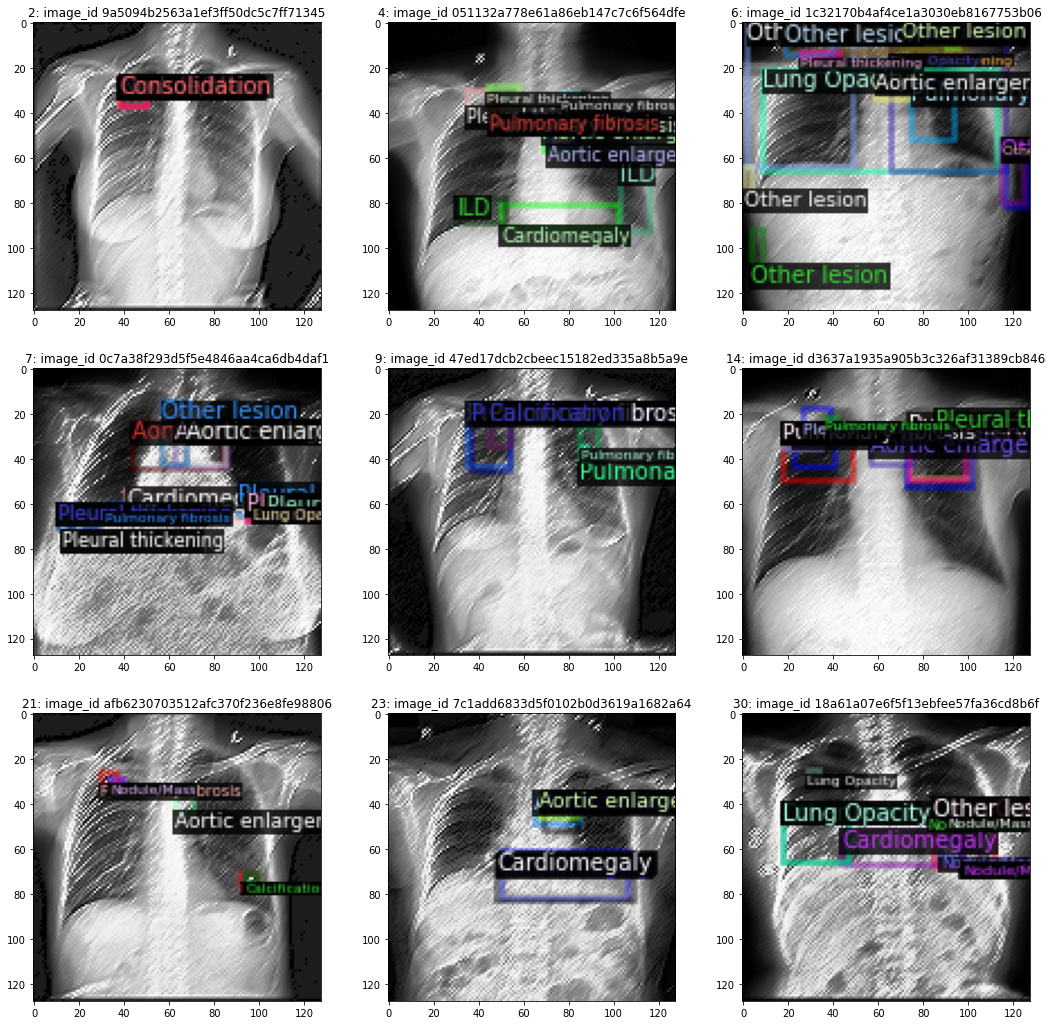

In [23]:
# Visualize data...
anomaly_image_ids = train.query("class_id != 14")["image_id"].unique()
train_meta = pd.read_csv(imgdir/"train_meta.csv")
anomaly_inds = np.argwhere(train_meta["image_id"].isin(anomaly_image_ids).values)[:, 0]

vinbigdata_metadata = MetadataCatalog.get("vinbigdata_train")

cols = 3
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
axes = axes.flatten()

for index, anom_ind in enumerate(anomaly_inds[:cols * rows]):
    ax = axes[index]
    # print(anom_ind)
    d = dataset_dicts[anom_ind]
    img = cv2.imread(d["file_name"])

#     img = cv2.GaussianBlur(img, (3,3), 10) #Gaussian Filter
#     img = alpha_filter(img, 1.41) #Alpha-Trimmed Mean Filter
    
#     kernel = cv2.getGaborKernel((9, 9), 1.0, np.pi/4, 1.0, 0.5, 0, ktype=cv2.CV_32F) # Gabor Filte
#     img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
    
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     img[2] = cv2.equalizeHist(img[2])
#     img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    
#     norm_img = np.zeros((img.shape[0], img.shape[1]))
#     img = cv2.normalize(img,  norm_img, 0, 255, cv2.NORM_MINMAX)

    
    # Adaptive Median Filter, Alpha-Trimmed Mean Filter, Gaussian Filter,
    # Gabor Filter, High Pass Filter, Laplacian Filter, and Bilateral Filter. H.
    # Kim et al. [20] used the Median Filter (the kernel size is 3 × 3) and
    # Top-hat filter to reduce image noise and to smooth it
    
        
    visualizer = Visualizer(img[:, :, ::-1], metadata=vinbigdata_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # cv2_imshow(out.get_image()[:, :, ::-1])
    #cv2.imwrite(str(outdir / f"vinbigdata{index}.jpg"), out.get_image()[:, :, ::-1])
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.set_title(f"{anom_ind}: image_id {anomaly_image_ids[index]}")

<a id="training"></a>
# Training

In [24]:
from detectron2.config.config import CfgNode as CN

cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)  # pass aug_kwargs to cfg

original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("vinbigdata_train",)
if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = ("vinbigdata_valid",)
    cfg.TEST.EVAL_PERIOD = flags.eval_period

cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


cfg.OUTPUT_DIR ./output -> results/v9


In [25]:
# #For loading pretained model

# trainer = MyTrainer(cfg)
# trainer.resume_or_load(resume=True)

In [26]:
#For training

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/12 13:11:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  GaussNoise(always_apply=False, p=0.5, var_limit=(10.0, 50.0)),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
[06/12 13:11:18 d2.data.build]: Removed 8470 images with no usable annotations. 3530 images left.
[06/12 13:11:18 d2.data.build]: Distribution of instances among all 14 cat

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.


[06/12 13:11:20 d2.engine.train_loop]: Starting training from iteration 0


/home/weronika/.local/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning:

This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)



[06/12 13:11:31 d2.utils.events]:  eta: 1:22:40  iter: 19  total_loss: 4.915  loss_cls: 2.612  loss_box_reg: 0.02113  loss_rpn_cls: 2.048  loss_rpn_loc: 0.2397  time: 0.5021  data_time: 0.0096  lr: 1.9516e-05  max_mem: 740M
[06/12 13:11:40 d2.utils.events]:  eta: 1:21:40  iter: 39  total_loss: 2.752  loss_cls: 1.74  loss_box_reg: 0.04839  loss_rpn_cls: 0.5107  loss_rpn_loc: 0.2443  time: 0.4980  data_time: 0.0030  lr: 3.9007e-05  max_mem: 740M
[06/12 13:11:51 d2.utils.events]:  eta: 1:21:55  iter: 59  total_loss: 1.022  loss_cls: 0.3961  loss_box_reg: 0.06323  loss_rpn_cls: 0.3589  loss_rpn_loc: 0.06622  time: 0.5047  data_time: 0.0032  lr: 5.8497e-05  max_mem: 740M
[06/12 13:12:01 d2.utils.events]:  eta: 1:22:10  iter: 79  total_loss: 0.9875  loss_cls: 0.2709  loss_box_reg: 0.0856  loss_rpn_cls: 0.3787  loss_rpn_loc: 0.1593  time: 0.5096  data_time: 0.0037  lr: 7.7988e-05  max_mem: 740M
[06/12 13:12:12 d2.utils.events]:  eta: 1:23:28  iter: 99  total_loss: 0.7743  loss_cls: 0.2259  lo

[06/12 13:17:52 d2.utils.events]:  eta: 1:22:29  iter: 719  total_loss: 0.8812  loss_cls: 0.1983  loss_box_reg: 0.1714  loss_rpn_cls: 0.2228  loss_rpn_loc: 0.1732  time: 0.5426  data_time: 0.0055  lr: 0.00070169  max_mem: 740M
[06/12 13:18:02 d2.utils.events]:  eta: 1:22:15  iter: 739  total_loss: 0.7444  loss_cls: 0.1842  loss_box_reg: 0.1425  loss_rpn_cls: 0.2351  loss_rpn_loc: 0.1523  time: 0.5422  data_time: 0.0053  lr: 0.00072118  max_mem: 740M
[06/12 13:18:13 d2.utils.events]:  eta: 1:22:02  iter: 759  total_loss: 0.778  loss_cls: 0.2633  loss_box_reg: 0.1473  loss_rpn_cls: 0.2014  loss_rpn_loc: 0.09907  time: 0.5418  data_time: 0.0058  lr: 0.00074067  max_mem: 740M
[06/12 13:18:23 d2.utils.events]:  eta: 1:21:51  iter: 779  total_loss: 0.7571  loss_cls: 0.184  loss_box_reg: 0.1466  loss_rpn_cls: 0.2181  loss_rpn_loc: 0.1691  time: 0.5417  data_time: 0.0068  lr: 0.00076016  max_mem: 740M
[06/12 13:18:34 d2.utils.events]:  eta: 1:21:34  iter: 799  total_loss: 0.7103  loss_cls: 0.1

[06/12 13:23:40 d2.evaluation.evaluator]: Inference done 1496/3000. 0.1307 s / img. ETA=0:03:20
[06/12 13:23:45 d2.evaluation.evaluator]: Inference done 1534/3000. 0.1307 s / img. ETA=0:03:14
[06/12 13:23:50 d2.evaluation.evaluator]: Inference done 1572/3000. 0.1306 s / img. ETA=0:03:09
[06/12 13:23:55 d2.evaluation.evaluator]: Inference done 1610/3000. 0.1306 s / img. ETA=0:03:04
[06/12 13:24:00 d2.evaluation.evaluator]: Inference done 1648/3000. 0.1306 s / img. ETA=0:02:59
[06/12 13:24:05 d2.evaluation.evaluator]: Inference done 1686/3000. 0.1306 s / img. ETA=0:02:54
[06/12 13:24:10 d2.evaluation.evaluator]: Inference done 1724/3000. 0.1306 s / img. ETA=0:02:49
[06/12 13:24:15 d2.evaluation.evaluator]: Inference done 1760/3000. 0.1307 s / img. ETA=0:02:44
[06/12 13:24:20 d2.evaluation.evaluator]: Inference done 1798/3000. 0.1307 s / img. ETA=0:02:39
[06/12 13:24:25 d2.evaluation.evaluator]: Inference done 1836/3000. 0.1307 s / img. ETA=0:02:34
[06/12 13:24:30 d2.evaluation.evaluator]

[06/12 13:28:50 detectron2]: Loss on Validation  done 938/3000. 0.0001 s / img. ETA=0:03:44
[06/12 13:28:55 detectron2]: Loss on Validation  done 985/3000. 0.0001 s / img. ETA=0:03:38
[06/12 13:29:00 detectron2]: Loss on Validation  done 1031/3000. 0.0001 s / img. ETA=0:03:34
[06/12 13:29:05 detectron2]: Loss on Validation  done 1077/3000. 0.0001 s / img. ETA=0:03:29
[06/12 13:29:11 detectron2]: Loss on Validation  done 1124/3000. 0.0001 s / img. ETA=0:03:23
[06/12 13:29:16 detectron2]: Loss on Validation  done 1169/3000. 0.0001 s / img. ETA=0:03:19
[06/12 13:29:21 detectron2]: Loss on Validation  done 1216/3000. 0.0001 s / img. ETA=0:03:14
[06/12 13:29:26 detectron2]: Loss on Validation  done 1263/3000. 0.0001 s / img. ETA=0:03:08
[06/12 13:29:31 detectron2]: Loss on Validation  done 1309/3000. 0.0001 s / img. ETA=0:03:03
[06/12 13:29:36 detectron2]: Loss on Validation  done 1356/3000. 0.0001 s / img. ETA=0:02:58
[06/12 13:29:41 detectron2]: Loss on Validation  done 1402/3000. 0.0001 

[06/12 13:35:12 d2.utils.events]:  eta: 1:18:32  iter: 1279  total_loss: 0.7791  loss_cls: 0.1941  loss_box_reg: 0.1887  loss_rpn_cls: 0.2111  loss_rpn_loc: 0.15  validation_loss: 0.3692  time: 0.5432  data_time: 0.0056  lr: 0.00096018  max_mem: 740M
[06/12 13:35:24 d2.utils.events]:  eta: 1:18:18  iter: 1299  total_loss: 0.6984  loss_cls: 0.1843  loss_box_reg: 0.1523  loss_rpn_cls: 0.2088  loss_rpn_loc: 0.1137  validation_loss: 0.3692  time: 0.5433  data_time: 0.0056  lr: 0.00095894  max_mem: 740M
[06/12 13:35:35 d2.utils.events]:  eta: 1:18:07  iter: 1319  total_loss: 0.6768  loss_cls: 0.1952  loss_box_reg: 0.1642  loss_rpn_cls: 0.1972  loss_rpn_loc: 0.07976  validation_loss: 0.3692  time: 0.5435  data_time: 0.0055  lr: 0.00095768  max_mem: 740M
[06/12 13:35:46 d2.utils.events]:  eta: 1:17:59  iter: 1339  total_loss: 0.81  loss_cls: 0.2104  loss_box_reg: 0.1504  loss_rpn_cls: 0.2447  loss_rpn_loc: 0.1647  validation_loss: 0.3692  time: 0.5436  data_time: 0.0057  lr: 0.00095641  max_m

[06/12 13:41:35 d2.utils.events]:  eta: 1:14:47  iter: 1919  total_loss: 0.6492  loss_cls: 0.1702  loss_box_reg: 0.1833  loss_rpn_cls: 0.1464  loss_rpn_loc: 0.08725  validation_loss: 0.3692  time: 0.5610  data_time: 0.0082  lr: 0.00091186  max_mem: 740M
[06/12 13:41:48 d2.utils.events]:  eta: 1:14:43  iter: 1939  total_loss: 0.5805  loss_cls: 0.1657  loss_box_reg: 0.1473  loss_rpn_cls: 0.1472  loss_rpn_loc: 0.07967  validation_loss: 0.3692  time: 0.5618  data_time: 0.0074  lr: 0.00091007  max_mem: 740M
[06/12 13:42:01 d2.utils.events]:  eta: 1:14:39  iter: 1959  total_loss: 1.034  loss_cls: 0.2407  loss_box_reg: 0.2399  loss_rpn_cls: 0.1754  loss_rpn_loc: 0.1489  validation_loss: 0.3692  time: 0.5630  data_time: 0.0087  lr: 0.00090826  max_mem: 740M
[06/12 13:42:15 d2.utils.events]:  eta: 1:14:36  iter: 1979  total_loss: 0.7873  loss_cls: 0.1725  loss_box_reg: 0.1476  loss_rpn_cls: 0.1845  loss_rpn_loc: 0.1379  validation_loss: 0.3692  time: 0.5640  data_time: 0.0086  lr: 0.00090644  m

[06/12 13:47:52 d2.evaluation.evaluator]: Inference done 1987/3000. 0.1587 s / img. ETA=0:02:44
[06/12 13:47:57 d2.evaluation.evaluator]: Inference done 2020/3000. 0.1586 s / img. ETA=0:02:38
[06/12 13:48:02 d2.evaluation.evaluator]: Inference done 2054/3000. 0.1584 s / img. ETA=0:02:32
[06/12 13:48:07 d2.evaluation.evaluator]: Inference done 2088/3000. 0.1582 s / img. ETA=0:02:27
[06/12 13:48:12 d2.evaluation.evaluator]: Inference done 2120/3000. 0.1582 s / img. ETA=0:02:22
[06/12 13:48:17 d2.evaluation.evaluator]: Inference done 2150/3000. 0.1582 s / img. ETA=0:02:17
[06/12 13:48:22 d2.evaluation.evaluator]: Inference done 2180/3000. 0.1583 s / img. ETA=0:02:12
[06/12 13:48:27 d2.evaluation.evaluator]: Inference done 2207/3000. 0.1586 s / img. ETA=0:02:08
[06/12 13:48:32 d2.evaluation.evaluator]: Inference done 2235/3000. 0.1589 s / img. ETA=0:02:04
[06/12 13:48:37 d2.evaluation.evaluator]: Inference done 2264/3000. 0.1590 s / img. ETA=0:01:59
[06/12 13:48:42 d2.evaluation.evaluator]

[06/12 13:53:07 detectron2]: Loss on Validation  done 977/3000. 0.0001 s / img. ETA=0:04:36
[06/12 13:53:12 detectron2]: Loss on Validation  done 1015/3000. 0.0001 s / img. ETA=0:04:30
[06/12 13:53:17 detectron2]: Loss on Validation  done 1058/3000. 0.0001 s / img. ETA=0:04:23
[06/12 13:53:22 detectron2]: Loss on Validation  done 1088/3000. 0.0001 s / img. ETA=0:04:20
[06/12 13:53:27 detectron2]: Loss on Validation  done 1119/3000. 0.0001 s / img. ETA=0:04:18
[06/12 13:53:32 detectron2]: Loss on Validation  done 1153/3000. 0.0001 s / img. ETA=0:04:13
[06/12 13:53:37 detectron2]: Loss on Validation  done 1193/3000. 0.0001 s / img. ETA=0:04:07
[06/12 13:53:42 detectron2]: Loss on Validation  done 1235/3000. 0.0001 s / img. ETA=0:04:01
[06/12 13:53:47 detectron2]: Loss on Validation  done 1279/3000. 0.0001 s / img. ETA=0:03:53
[06/12 13:53:53 detectron2]: Loss on Validation  done 1314/3000. 0.0001 s / img. ETA=0:03:49
[06/12 13:53:58 detectron2]: Loss on Validation  done 1348/3000. 0.0001

[06/12 14:00:17 d2.utils.events]:  eta: 1:17:07  iter: 2199  total_loss: 0.5794  loss_cls: 0.1337  loss_box_reg: 0.1495  loss_rpn_cls: 0.1592  loss_rpn_loc: 0.06731  validation_loss: 0.3547  time: 0.5836  data_time: 0.0098  lr: 0.00088536  max_mem: 740M
[06/12 14:00:31 d2.utils.events]:  eta: 1:18:01  iter: 2219  total_loss: 0.6118  loss_cls: 0.1447  loss_box_reg: 0.139  loss_rpn_cls: 0.1718  loss_rpn_loc: 0.08275  validation_loss: 0.3547  time: 0.5846  data_time: 0.0068  lr: 0.00088335  max_mem: 740M
[06/12 14:00:45 d2.utils.events]:  eta: 1:18:53  iter: 2239  total_loss: 0.6579  loss_cls: 0.1979  loss_box_reg: 0.1668  loss_rpn_cls: 0.1602  loss_rpn_loc: 0.09167  validation_loss: 0.3547  time: 0.5857  data_time: 0.0070  lr: 0.00088132  max_mem: 740M
[06/12 14:00:58 d2.utils.events]:  eta: 1:19:04  iter: 2259  total_loss: 0.7539  loss_cls: 0.2357  loss_box_reg: 0.1663  loss_rpn_cls: 0.1531  loss_rpn_loc: 0.07984  validation_loss: 0.3547  time: 0.5863  data_time: 0.0061  lr: 0.00087928 

[06/12 14:08:24 d2.utils.events]:  eta: 1:26:02  iter: 2839  total_loss: 0.7518  loss_cls: 0.172  loss_box_reg: 0.1773  loss_rpn_cls: 0.1689  loss_rpn_loc: 0.09621  validation_loss: 0.3547  time: 0.6234  data_time: 0.0074  lr: 0.00081397  max_mem: 740M
[06/12 14:08:39 d2.utils.events]:  eta: 1:26:04  iter: 2859  total_loss: 0.6496  loss_cls: 0.1529  loss_box_reg: 0.137  loss_rpn_cls: 0.1553  loss_rpn_loc: 0.1262  validation_loss: 0.3547  time: 0.6243  data_time: 0.0079  lr: 0.00081152  max_mem: 740M
[06/12 14:08:55 d2.utils.events]:  eta: 1:26:20  iter: 2879  total_loss: 0.6933  loss_cls: 0.1863  loss_box_reg: 0.1945  loss_rpn_cls: 0.1595  loss_rpn_loc: 0.1336  validation_loss: 0.3547  time: 0.6253  data_time: 0.0091  lr: 0.00080905  max_mem: 740M
[06/12 14:09:10 d2.utils.events]:  eta: 1:26:22  iter: 2899  total_loss: 0.6198  loss_cls: 0.1344  loss_box_reg: 0.1317  loss_rpn_cls: 0.1346  loss_rpn_loc: 0.09273  validation_loss: 0.3547  time: 0.6263  data_time: 0.0083  lr: 0.00080658  ma

[06/12 14:15:00 d2.evaluation.evaluator]: Inference done 1430/3000. 0.1880 s / img. ETA=0:05:00
[06/12 14:15:05 d2.evaluation.evaluator]: Inference done 1459/3000. 0.1877 s / img. ETA=0:04:54
[06/12 14:15:10 d2.evaluation.evaluator]: Inference done 1486/3000. 0.1876 s / img. ETA=0:04:49
[06/12 14:15:15 d2.evaluation.evaluator]: Inference done 1515/3000. 0.1874 s / img. ETA=0:04:43
[06/12 14:15:20 d2.evaluation.evaluator]: Inference done 1543/3000. 0.1872 s / img. ETA=0:04:37
[06/12 14:15:25 d2.evaluation.evaluator]: Inference done 1569/3000. 0.1873 s / img. ETA=0:04:33
[06/12 14:15:31 d2.evaluation.evaluator]: Inference done 1595/3000. 0.1875 s / img. ETA=0:04:28
[06/12 14:15:36 d2.evaluation.evaluator]: Inference done 1618/3000. 0.1879 s / img. ETA=0:04:24
[06/12 14:15:41 d2.evaluation.evaluator]: Inference done 1646/3000. 0.1878 s / img. ETA=0:04:18
[06/12 14:15:46 d2.evaluation.evaluator]: Inference done 1676/3000. 0.1874 s / img. ETA=0:04:12
[06/12 14:15:51 d2.evaluation.evaluator]

[06/12 14:20:13 detectron2]: Loss on Validation  done 43/3000. 0.0001 s / img. ETA=0:07:22
[06/12 14:20:18 detectron2]: Loss on Validation  done 80/3000. 0.0001 s / img. ETA=0:07:00
[06/12 14:20:23 detectron2]: Loss on Validation  done 117/3000. 0.0001 s / img. ETA=0:06:48
[06/12 14:20:29 detectron2]: Loss on Validation  done 155/3000. 0.0001 s / img. ETA=0:06:36
[06/12 14:20:34 detectron2]: Loss on Validation  done 192/3000. 0.0001 s / img. ETA=0:06:29
[06/12 14:20:39 detectron2]: Loss on Validation  done 231/3000. 0.0001 s / img. ETA=0:06:19
[06/12 14:20:44 detectron2]: Loss on Validation  done 271/3000. 0.0001 s / img. ETA=0:06:09
[06/12 14:20:49 detectron2]: Loss on Validation  done 308/3000. 0.0001 s / img. ETA=0:06:05
[06/12 14:20:54 detectron2]: Loss on Validation  done 338/3000. 0.0001 s / img. ETA=0:06:09
[06/12 14:20:59 detectron2]: Loss on Validation  done 372/3000. 0.0001 s / img. ETA=0:06:07
[06/12 14:21:04 detectron2]: Loss on Validation  done 404/3000. 0.0001 s / img. ET

[06/12 14:27:05 detectron2]: Loss on Validation  done 2925/3000. 0.0001 s / img. ETA=0:00:10
[06/12 14:27:10 detectron2]: Loss on Validation  done 2961/3000. 0.0001 s / img. ETA=0:00:05
[06/12 14:27:15 detectron2]: Loss on Validation  done 2995/3000. 0.0001 s / img. ETA=0:00:00
validation do loss eval 0.3160955555598096
[06/12 14:27:16 d2.utils.events]:  eta: 1:25:55  iter: 2999  total_loss: 0.7202  loss_cls: 0.1727  loss_box_reg: 0.1951  loss_rpn_cls: 0.1503  loss_rpn_loc: 0.1272  validation_loss: 0.3402  time: 0.6305  data_time: 0.0081  lr: 0.00079402  max_mem: 740M
[06/12 14:27:31 d2.utils.events]:  eta: 1:25:41  iter: 3019  total_loss: 0.6184  loss_cls: 0.1449  loss_box_reg: 0.1539  loss_rpn_cls: 0.1399  loss_rpn_loc: 0.07948  validation_loss: 0.3402  time: 0.6315  data_time: 0.0095  lr: 0.00079147  max_mem: 740M
[06/12 14:27:47 d2.utils.events]:  eta: 1:25:43  iter: 3039  total_loss: 0.8975  loss_cls: 0.2193  loss_box_reg: 0.1927  loss_rpn_cls: 0.1655  loss_rpn_loc: 0.1496  valida

[06/12 14:34:51 d2.utils.events]:  eta: 1:18:02  iter: 3599  total_loss: 0.737  loss_cls: 0.2186  loss_box_reg: 0.1641  loss_rpn_cls: 0.1507  loss_rpn_loc: 0.08012  validation_loss: 0.3402  time: 0.6516  data_time: 0.0070  lr: 0.00071303  max_mem: 740M
[06/12 14:35:03 d2.utils.events]:  eta: 1:17:36  iter: 3619  total_loss: 0.8397  loss_cls: 0.2516  loss_box_reg: 0.2369  loss_rpn_cls: 0.1736  loss_rpn_loc: 0.1173  validation_loss: 0.3402  time: 0.6515  data_time: 0.0067  lr: 0.00071019  max_mem: 740M
[06/12 14:35:17 d2.utils.events]:  eta: 1:17:13  iter: 3639  total_loss: 0.827  loss_cls: 0.1376  loss_box_reg: 0.1467  loss_rpn_cls: 0.1973  loss_rpn_loc: 0.1608  validation_loss: 0.3402  time: 0.6518  data_time: 0.0066  lr: 0.00070733  max_mem: 740M
[06/12 14:35:31 d2.utils.events]:  eta: 1:16:36  iter: 3659  total_loss: 0.7021  loss_cls: 0.208  loss_box_reg: 0.1747  loss_rpn_cls: 0.1771  loss_rpn_loc: 0.1033  validation_loss: 0.3402  time: 0.6519  data_time: 0.0069  lr: 0.00070447  max_

[06/12 14:41:35 d2.evaluation.evaluator]: Inference done 662/3000. 0.1762 s / img. ETA=0:07:00
[06/12 14:41:40 d2.evaluation.evaluator]: Inference done 691/3000. 0.1760 s / img. ETA=0:06:55
[06/12 14:41:45 d2.evaluation.evaluator]: Inference done 720/3000. 0.1759 s / img. ETA=0:06:49
[06/12 14:41:50 d2.evaluation.evaluator]: Inference done 750/3000. 0.1756 s / img. ETA=0:06:43
[06/12 14:41:55 d2.evaluation.evaluator]: Inference done 779/3000. 0.1754 s / img. ETA=0:06:37
[06/12 14:42:00 d2.evaluation.evaluator]: Inference done 809/3000. 0.1752 s / img. ETA=0:06:31
[06/12 14:42:05 d2.evaluation.evaluator]: Inference done 837/3000. 0.1753 s / img. ETA=0:06:27
[06/12 14:42:10 d2.evaluation.evaluator]: Inference done 865/3000. 0.1753 s / img. ETA=0:06:22
[06/12 14:42:15 d2.evaluation.evaluator]: Inference done 893/3000. 0.1755 s / img. ETA=0:06:17
[06/12 14:42:21 d2.evaluation.evaluator]: Inference done 920/3000. 0.1757 s / img. ETA=0:06:13
[06/12 14:42:26 d2.evaluation.evaluator]: Inferenc

[06/12 14:48:17 d2.evaluation.evaluator]: Inference done 2998/3000. 0.1706 s / img. ETA=0:00:00
[06/12 14:48:17 d2.evaluation.evaluator]: Total inference time: 0:08:40.939857 (0.173937 s / img per device, on 1 devices)
[06/12 14:48:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:08:30 (0.170571 s / img per device, on 1 devices)
Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
[06/12 14:48:19 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[06/12 14:48:21 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 2.61 seconds.
[06/12 14:48:21 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[06/12 14:48:22 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.50 seconds.
 Average Precision  (AP) @[ IoU=0.40:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.40      | area=   all | 

[06/12 14:53:28 detectron2]: Loss on Validation  done 2052/3000. 0.0001 s / img. ETA=0:02:21
[06/12 14:53:33 detectron2]: Loss on Validation  done 2091/3000. 0.0001 s / img. ETA=0:02:15
[06/12 14:53:39 detectron2]: Loss on Validation  done 2132/3000. 0.0001 s / img. ETA=0:02:08
[06/12 14:53:44 detectron2]: Loss on Validation  done 2169/3000. 0.0001 s / img. ETA=0:02:03
[06/12 14:53:49 detectron2]: Loss on Validation  done 2202/3000. 0.0001 s / img. ETA=0:01:58
[06/12 14:53:54 detectron2]: Loss on Validation  done 2242/3000. 0.0001 s / img. ETA=0:01:52
[06/12 14:53:59 detectron2]: Loss on Validation  done 2274/3000. 0.0001 s / img. ETA=0:01:47
[06/12 14:54:04 detectron2]: Loss on Validation  done 2307/3000. 0.0001 s / img. ETA=0:01:42
[06/12 14:54:09 detectron2]: Loss on Validation  done 2341/3000. 0.0001 s / img. ETA=0:01:37
[06/12 14:54:14 detectron2]: Loss on Validation  done 2383/3000. 0.0001 s / img. ETA=0:01:31
[06/12 14:54:19 detectron2]: Loss on Validation  done 2424/3000. 0.000

[06/12 15:00:41 d2.utils.events]:  eta: 1:04:23  iter: 4419  total_loss: 0.58  loss_cls: 0.1611  loss_box_reg: 0.1667  loss_rpn_cls: 0.1562  loss_rpn_loc: 0.07347  validation_loss: 0.3282  time: 0.6628  data_time: 0.0078  lr: 0.00059076  max_mem: 740M
[06/12 15:00:54 d2.utils.events]:  eta: 1:04:02  iter: 4439  total_loss: 0.6082  loss_cls: 0.1838  loss_box_reg: 0.2072  loss_rpn_cls: 0.1366  loss_rpn_loc: 0.09353  validation_loss: 0.3282  time: 0.6627  data_time: 0.0066  lr: 0.00058767  max_mem: 740M
[06/12 15:01:07 d2.utils.events]:  eta: 1:03:37  iter: 4459  total_loss: 0.6986  loss_cls: 0.15  loss_box_reg: 0.1708  loss_rpn_cls: 0.1769  loss_rpn_loc: 0.0911  validation_loss: 0.3282  time: 0.6626  data_time: 0.0069  lr: 0.00058457  max_mem: 740M
[06/12 15:01:20 d2.utils.events]:  eta: 1:03:12  iter: 4479  total_loss: 0.567  loss_cls: 0.158  loss_box_reg: 0.1515  loss_rpn_cls: 0.1276  loss_rpn_loc: 0.0679  validation_loss: 0.3282  time: 0.6626  data_time: 0.0079  lr: 0.00058147  max_me

[06/12 15:07:24 d2.evaluation.evaluator]: Inference done 45/3000. 0.1446 s / img. ETA=0:07:14
[06/12 15:07:30 d2.evaluation.evaluator]: Inference done 72/3000. 0.1615 s / img. ETA=0:08:01
[06/12 15:07:35 d2.evaluation.evaluator]: Inference done 105/3000. 0.1576 s / img. ETA=0:07:44
[06/12 15:07:40 d2.evaluation.evaluator]: Inference done 135/3000. 0.1601 s / img. ETA=0:07:46
[06/12 15:07:45 d2.evaluation.evaluator]: Inference done 165/3000. 0.1614 s / img. ETA=0:07:46
[06/12 15:07:50 d2.evaluation.evaluator]: Inference done 197/3000. 0.1609 s / img. ETA=0:07:39
[06/12 15:07:55 d2.evaluation.evaluator]: Inference done 229/3000. 0.1605 s / img. ETA=0:07:32
[06/12 15:08:00 d2.evaluation.evaluator]: Inference done 260/3000. 0.1604 s / img. ETA=0:07:27
[06/12 15:08:05 d2.evaluation.evaluator]: Inference done 292/3000. 0.1600 s / img. ETA=0:07:20
[06/12 15:08:10 d2.evaluation.evaluator]: Inference done 325/3000. 0.1589 s / img. ETA=0:07:12
[06/12 15:08:15 d2.evaluation.evaluator]: Inference 

[06/12 15:14:06 d2.evaluation.evaluator]: Inference done 2662/3000. 0.1501 s / img. ETA=0:00:51
[06/12 15:14:11 d2.evaluation.evaluator]: Inference done 2696/3000. 0.1501 s / img. ETA=0:00:46
[06/12 15:14:16 d2.evaluation.evaluator]: Inference done 2729/3000. 0.1501 s / img. ETA=0:00:41
[06/12 15:14:21 d2.evaluation.evaluator]: Inference done 2763/3000. 0.1501 s / img. ETA=0:00:36
[06/12 15:14:27 d2.evaluation.evaluator]: Inference done 2797/3000. 0.1500 s / img. ETA=0:00:31
[06/12 15:14:32 d2.evaluation.evaluator]: Inference done 2831/3000. 0.1500 s / img. ETA=0:00:25
[06/12 15:14:37 d2.evaluation.evaluator]: Inference done 2866/3000. 0.1499 s / img. ETA=0:00:20
[06/12 15:14:42 d2.evaluation.evaluator]: Inference done 2898/3000. 0.1499 s / img. ETA=0:00:15
[06/12 15:14:47 d2.evaluation.evaluator]: Inference done 2931/3000. 0.1499 s / img. ETA=0:00:10
[06/12 15:14:52 d2.evaluation.evaluator]: Inference done 2965/3000. 0.1499 s / img. ETA=0:00:05
[06/12 15:14:57 d2.evaluation.evaluator]

[06/12 15:19:19 detectron2]: Loss on Validation  done 2031/3000. 0.0001 s / img. ETA=0:02:01
[06/12 15:19:24 detectron2]: Loss on Validation  done 2062/3000. 0.0001 s / img. ETA=0:01:57
[06/12 15:19:29 detectron2]: Loss on Validation  done 2092/3000. 0.0001 s / img. ETA=0:01:54
[06/12 15:19:34 detectron2]: Loss on Validation  done 2125/3000. 0.0001 s / img. ETA=0:01:51
[06/12 15:19:39 detectron2]: Loss on Validation  done 2162/3000. 0.0001 s / img. ETA=0:01:46
[06/12 15:19:44 detectron2]: Loss on Validation  done 2201/3000. 0.0001 s / img. ETA=0:01:41
[06/12 15:19:49 detectron2]: Loss on Validation  done 2243/3000. 0.0001 s / img. ETA=0:01:36
[06/12 15:19:54 detectron2]: Loss on Validation  done 2285/3000. 0.0001 s / img. ETA=0:01:30
[06/12 15:19:59 detectron2]: Loss on Validation  done 2327/3000. 0.0001 s / img. ETA=0:01:25
[06/12 15:20:05 detectron2]: Loss on Validation  done 2370/3000. 0.0001 s / img. ETA=0:01:19
[06/12 15:20:10 detectron2]: Loss on Validation  done 2403/3000. 0.000

[06/12 15:25:27 d2.utils.events]:  eta: 0:44:36  iter: 5439  total_loss: 0.576  loss_cls: 0.1776  loss_box_reg: 0.1598  loss_rpn_cls: 0.1461  loss_rpn_loc: 0.08359  validation_loss: 0.3161  time: 0.6562  data_time: 0.0056  lr: 0.00043126  max_mem: 740M
[06/12 15:25:38 d2.utils.events]:  eta: 0:44:04  iter: 5459  total_loss: 0.7842  loss_cls: 0.2243  loss_box_reg: 0.1729  loss_rpn_cls: 0.1664  loss_rpn_loc: 0.1786  validation_loss: 0.3161  time: 0.6558  data_time: 0.0057  lr: 0.00042815  max_mem: 740M
[06/12 15:25:49 d2.utils.events]:  eta: 0:43:38  iter: 5479  total_loss: 0.5986  loss_cls: 0.1338  loss_box_reg: 0.1668  loss_rpn_cls: 0.1576  loss_rpn_loc: 0.07235  validation_loss: 0.3161  time: 0.6554  data_time: 0.0069  lr: 0.00042504  max_mem: 740M
[06/12 15:26:01 d2.utils.events]:  eta: 0:43:04  iter: 5499  total_loss: 0.5949  loss_cls: 0.181  loss_box_reg: 0.1972  loss_rpn_cls: 0.1323  loss_rpn_loc: 0.08606  validation_loss: 0.3161  time: 0.6551  data_time: 0.0059  lr: 0.00042194  m

[06/12 15:30:54 d2.evaluation.evaluator]: Inference done 112/3000. 0.1485 s / img. ETA=0:07:18
[06/12 15:30:59 d2.evaluation.evaluator]: Inference done 147/3000. 0.1475 s / img. ETA=0:07:10
[06/12 15:31:04 d2.evaluation.evaluator]: Inference done 178/3000. 0.1494 s / img. ETA=0:07:11
[06/12 15:31:09 d2.evaluation.evaluator]: Inference done 211/3000. 0.1492 s / img. ETA=0:07:05
[06/12 15:31:14 d2.evaluation.evaluator]: Inference done 245/3000. 0.1488 s / img. ETA=0:06:59
[06/12 15:31:19 d2.evaluation.evaluator]: Inference done 274/3000. 0.1511 s / img. ETA=0:07:01
[06/12 15:31:24 d2.evaluation.evaluator]: Inference done 306/3000. 0.1516 s / img. ETA=0:06:58
[06/12 15:31:29 d2.evaluation.evaluator]: Inference done 339/3000. 0.1514 s / img. ETA=0:06:52
[06/12 15:31:34 d2.evaluation.evaluator]: Inference done 370/3000. 0.1519 s / img. ETA=0:06:49
[06/12 15:31:40 d2.evaluation.evaluator]: Inference done 402/3000. 0.1521 s / img. ETA=0:06:45
[06/12 15:31:45 d2.evaluation.evaluator]: Inferenc

[06/12 15:37:35 d2.evaluation.evaluator]: Inference done 2842/3000. 0.1440 s / img. ETA=0:00:23
[06/12 15:37:40 d2.evaluation.evaluator]: Inference done 2879/3000. 0.1439 s / img. ETA=0:00:17
[06/12 15:37:45 d2.evaluation.evaluator]: Inference done 2915/3000. 0.1438 s / img. ETA=0:00:12
[06/12 15:37:50 d2.evaluation.evaluator]: Inference done 2952/3000. 0.1437 s / img. ETA=0:00:07
[06/12 15:37:55 d2.evaluation.evaluator]: Inference done 2989/3000. 0.1436 s / img. ETA=0:00:01
[06/12 15:37:57 d2.evaluation.evaluator]: Total inference time: 0:07:19.028618 (0.146587 s / img per device, on 1 devices)
[06/12 15:37:57 d2.evaluation.evaluator]: Total inference pure compute time: 0:07:09 (0.143545 s / img per device, on 1 devices)
Loading and preparing results...
DONE (t=0.55s)
creating index...
index created!
[06/12 15:37:59 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[06/12 15:38:03 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 3.51 seconds.
[06/12 15:38:

[06/12 15:42:49 detectron2]: Loss on Validation  done 2377/3000. 0.0001 s / img. ETA=0:01:14
[06/12 15:42:54 detectron2]: Loss on Validation  done 2422/3000. 0.0001 s / img. ETA=0:01:09
[06/12 15:42:59 detectron2]: Loss on Validation  done 2467/3000. 0.0001 s / img. ETA=0:01:03
[06/12 15:43:04 detectron2]: Loss on Validation  done 2513/3000. 0.0001 s / img. ETA=0:00:58
[06/12 15:43:09 detectron2]: Loss on Validation  done 2556/3000. 0.0001 s / img. ETA=0:00:53
[06/12 15:43:14 detectron2]: Loss on Validation  done 2599/3000. 0.0001 s / img. ETA=0:00:47
[06/12 15:43:19 detectron2]: Loss on Validation  done 2639/3000. 0.0001 s / img. ETA=0:00:43
[06/12 15:43:25 detectron2]: Loss on Validation  done 2680/3000. 0.0001 s / img. ETA=0:00:38
[06/12 15:43:30 detectron2]: Loss on Validation  done 2725/3000. 0.0001 s / img. ETA=0:00:32
[06/12 15:43:35 detectron2]: Loss on Validation  done 2766/3000. 0.0001 s / img. ETA=0:00:27
[06/12 15:43:40 detectron2]: Loss on Validation  done 2806/3000. 0.000

[06/12 15:49:17 d2.utils.events]:  eta: 0:32:21  iter: 6519  total_loss: 0.5962  loss_cls: 0.1346  loss_box_reg: 0.159  loss_rpn_cls: 0.113  loss_rpn_loc: 0.06428  validation_loss: 0.3243  time: 0.6425  data_time: 0.0108  lr: 0.00027035  max_mem: 740M
[06/12 15:49:29 d2.utils.events]:  eta: 0:32:14  iter: 6539  total_loss: 0.6041  loss_cls: 0.1436  loss_box_reg: 0.155  loss_rpn_cls: 0.1227  loss_rpn_loc: 0.1005  validation_loss: 0.3243  time: 0.6424  data_time: 0.0105  lr: 0.00026756  max_mem: 740M
[06/12 15:49:42 d2.utils.events]:  eta: 0:32:09  iter: 6559  total_loss: 0.6426  loss_cls: 0.1789  loss_box_reg: 0.1996  loss_rpn_cls: 0.09924  loss_rpn_loc: 0.06691  validation_loss: 0.3243  time: 0.6424  data_time: 0.0112  lr: 0.00026479  max_mem: 740M
[06/12 15:49:55 d2.utils.events]:  eta: 0:32:03  iter: 6579  total_loss: 0.5619  loss_cls: 0.1641  loss_box_reg: 0.1939  loss_rpn_cls: 0.1045  loss_rpn_loc: 0.06869  validation_loss: 0.3243  time: 0.6423  data_time: 0.0087  lr: 0.00026202  m

[06/12 15:54:54 d2.evaluation.evaluator]: Inference done 501/3000. 0.1324 s / img. ETA=0:05:36
[06/12 15:54:59 d2.evaluation.evaluator]: Inference done 539/3000. 0.1323 s / img. ETA=0:05:31
[06/12 15:55:04 d2.evaluation.evaluator]: Inference done 577/3000. 0.1322 s / img. ETA=0:05:26
[06/12 15:55:09 d2.evaluation.evaluator]: Inference done 615/3000. 0.1322 s / img. ETA=0:05:21
[06/12 15:55:14 d2.evaluation.evaluator]: Inference done 653/3000. 0.1322 s / img. ETA=0:05:15
[06/12 15:55:19 d2.evaluation.evaluator]: Inference done 691/3000. 0.1321 s / img. ETA=0:05:10
[06/12 15:55:24 d2.evaluation.evaluator]: Inference done 729/3000. 0.1321 s / img. ETA=0:05:05
[06/12 15:55:29 d2.evaluation.evaluator]: Inference done 767/3000. 0.1321 s / img. ETA=0:05:00
[06/12 15:55:34 d2.evaluation.evaluator]: Inference done 805/3000. 0.1321 s / img. ETA=0:04:55
[06/12 15:55:39 d2.evaluation.evaluator]: Inference done 843/3000. 0.1321 s / img. ETA=0:04:50
[06/12 15:55:44 d2.evaluation.evaluator]: Inferenc

[06/12 16:00:40 d2.evaluation.testing]: copypaste: Task: bbox
[06/12 16:00:40 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[06/12 16:00:40 d2.evaluation.testing]: copypaste: 5.9062,10.8786,14.2858,3.3617,8.9700,11.2126
[06/12 16:00:41 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:04:19
[06/12 16:00:46 detectron2]: Loss on Validation  done 59/3000. 0.0001 s / img. ETA=0:05:03
[06/12 16:00:52 detectron2]: Loss on Validation  done 107/3000. 0.0001 s / img. ETA=0:05:01
[06/12 16:00:57 detectron2]: Loss on Validation  done 154/3000. 0.0001 s / img. ETA=0:05:00
[06/12 16:01:02 detectron2]: Loss on Validation  done 201/3000. 0.0001 s / img. ETA=0:04:56
[06/12 16:01:07 detectron2]: Loss on Validation  done 249/3000. 0.0001 s / img. ETA=0:04:51
[06/12 16:01:12 detectron2]: Loss on Validation  done 296/3000. 0.0001 s / img. ETA=0:04:46
[06/12 16:01:17 detectron2]: Loss on Validation  done 344/3000. 0.0001 s / img. ETA=0:04:41
[06/12 16:01:22 detectron2]: Los

[06/12 16:07:09 d2.utils.events]:  eta: 0:26:36  iter: 7119  total_loss: 0.5107  loss_cls: 0.1413  loss_box_reg: 0.1683  loss_rpn_cls: 0.1088  loss_rpn_loc: 0.07846  validation_loss: 0.3161  time: 0.6351  data_time: 0.0056  lr: 0.00019119  max_mem: 740M
[06/12 16:07:20 d2.utils.events]:  eta: 0:26:21  iter: 7139  total_loss: 0.616  loss_cls: 0.1423  loss_box_reg: 0.1532  loss_rpn_cls: 0.1522  loss_rpn_loc: 0.1007  validation_loss: 0.3161  time: 0.6348  data_time: 0.0059  lr: 0.00018873  max_mem: 740M
[06/12 16:07:31 d2.utils.events]:  eta: 0:26:07  iter: 7159  total_loss: 0.5851  loss_cls: 0.1606  loss_box_reg: 0.1944  loss_rpn_cls: 0.1184  loss_rpn_loc: 0.08095  validation_loss: 0.3161  time: 0.6346  data_time: 0.0057  lr: 0.00018628  max_mem: 740M
[06/12 16:07:42 d2.utils.events]:  eta: 0:25:54  iter: 7179  total_loss: 0.7003  loss_cls: 0.1976  loss_box_reg: 0.1907  loss_rpn_cls: 0.1754  loss_rpn_loc: 0.1762  validation_loss: 0.3161  time: 0.6343  data_time: 0.0061  lr: 0.00018384  m

[06/12 16:12:59 d2.utils.events]:  eta: 0:20:16  iter: 7759  total_loss: 0.674  loss_cls: 0.228  loss_box_reg: 0.2217  loss_rpn_cls: 0.1419  loss_rpn_loc: 0.08746  validation_loss: 0.3161  time: 0.6277  data_time: 0.0058  lr: 0.00011888  max_mem: 740M
[06/12 16:13:10 d2.utils.events]:  eta: 0:20:05  iter: 7779  total_loss: 0.6367  loss_cls: 0.1755  loss_box_reg: 0.1509  loss_rpn_cls: 0.1277  loss_rpn_loc: 0.07999  validation_loss: 0.3161  time: 0.6275  data_time: 0.0055  lr: 0.00011685  max_mem: 740M
[06/12 16:13:21 d2.utils.events]:  eta: 0:19:55  iter: 7799  total_loss: 0.5799  loss_cls: 0.1606  loss_box_reg: 0.1468  loss_rpn_cls: 0.1696  loss_rpn_loc: 0.1322  validation_loss: 0.3161  time: 0.6273  data_time: 0.0059  lr: 0.00011484  max_mem: 740M
[06/12 16:13:32 d2.utils.events]:  eta: 0:19:44  iter: 7819  total_loss: 0.55  loss_cls: 0.1363  loss_box_reg: 0.1784  loss_rpn_cls: 0.09776  loss_rpn_loc: 0.06015  validation_loss: 0.3161  time: 0.6271  data_time: 0.0056  lr: 0.00011285  ma

[06/12 16:18:50 d2.evaluation.evaluator]: Inference done 1628/3000. 0.1324 s / img. ETA=0:03:04
[06/12 16:18:55 d2.evaluation.evaluator]: Inference done 1665/3000. 0.1324 s / img. ETA=0:03:00
[06/12 16:19:00 d2.evaluation.evaluator]: Inference done 1703/3000. 0.1324 s / img. ETA=0:02:54
[06/12 16:19:05 d2.evaluation.evaluator]: Inference done 1741/3000. 0.1324 s / img. ETA=0:02:49
[06/12 16:19:11 d2.evaluation.evaluator]: Inference done 1779/3000. 0.1323 s / img. ETA=0:02:44
[06/12 16:19:16 d2.evaluation.evaluator]: Inference done 1817/3000. 0.1323 s / img. ETA=0:02:39
[06/12 16:19:21 d2.evaluation.evaluator]: Inference done 1855/3000. 0.1323 s / img. ETA=0:02:34
[06/12 16:19:26 d2.evaluation.evaluator]: Inference done 1893/3000. 0.1323 s / img. ETA=0:02:29
[06/12 16:19:31 d2.evaluation.evaluator]: Inference done 1931/3000. 0.1323 s / img. ETA=0:02:24
[06/12 16:19:36 d2.evaluation.evaluator]: Inference done 1969/3000. 0.1323 s / img. ETA=0:02:18
[06/12 16:19:41 d2.evaluation.evaluator]

[06/12 16:23:59 detectron2]: Loss on Validation  done 1093/3000. 0.0001 s / img. ETA=0:03:25
[06/12 16:24:04 detectron2]: Loss on Validation  done 1140/3000. 0.0001 s / img. ETA=0:03:19
[06/12 16:24:09 detectron2]: Loss on Validation  done 1187/3000. 0.0001 s / img. ETA=0:03:14
[06/12 16:24:14 detectron2]: Loss on Validation  done 1234/3000. 0.0001 s / img. ETA=0:03:09
[06/12 16:24:19 detectron2]: Loss on Validation  done 1282/3000. 0.0001 s / img. ETA=0:03:04
[06/12 16:24:24 detectron2]: Loss on Validation  done 1329/3000. 0.0001 s / img. ETA=0:02:59
[06/12 16:24:29 detectron2]: Loss on Validation  done 1376/3000. 0.0001 s / img. ETA=0:02:54
[06/12 16:24:34 detectron2]: Loss on Validation  done 1423/3000. 0.0001 s / img. ETA=0:02:49
[06/12 16:24:39 detectron2]: Loss on Validation  done 1469/3000. 0.0001 s / img. ETA=0:02:44
[06/12 16:24:44 detectron2]: Loss on Validation  done 1514/3000. 0.0001 s / img. ETA=0:02:39
[06/12 16:24:49 detectron2]: Loss on Validation  done 1561/3000. 0.000

[06/12 16:30:12 d2.utils.events]:  eta: 0:15:25  iter: 8299  total_loss: 0.516  loss_cls: 0.1303  loss_box_reg: 0.1447  loss_rpn_cls: 0.1238  loss_rpn_loc: 0.05851  validation_loss: 0.3111  time: 0.6223  data_time: 0.0057  lr: 6.9709e-05  max_mem: 740M
[06/12 16:30:23 d2.utils.events]:  eta: 0:15:14  iter: 8319  total_loss: 0.7942  loss_cls: 0.1967  loss_box_reg: 0.1944  loss_rpn_cls: 0.1686  loss_rpn_loc: 0.1059  validation_loss: 0.3111  time: 0.6222  data_time: 0.0059  lr: 6.8117e-05  max_mem: 740M
[06/12 16:30:34 d2.utils.events]:  eta: 0:15:03  iter: 8339  total_loss: 0.8427  loss_cls: 0.2211  loss_box_reg: 0.2077  loss_rpn_cls: 0.1314  loss_rpn_loc: 0.104  validation_loss: 0.3111  time: 0.6220  data_time: 0.0053  lr: 6.6543e-05  max_mem: 740M
[06/12 16:30:45 d2.utils.events]:  eta: 0:14:52  iter: 8359  total_loss: 0.9646  loss_cls: 0.2181  loss_box_reg: 0.2219  loss_rpn_cls: 0.1842  loss_rpn_loc: 0.1942  validation_loss: 0.3111  time: 0.6218  data_time: 0.0057  lr: 6.4986e-05  max

[06/12 16:36:04 d2.utils.events]:  eta: 0:09:38  iter: 8939  total_loss: 0.7139  loss_cls: 0.2101  loss_box_reg: 0.1963  loss_rpn_cls: 0.133  loss_rpn_loc: 0.1032  validation_loss: 0.3111  time: 0.6171  data_time: 0.0055  lr: 2.752e-05  max_mem: 740M
[06/12 16:36:15 d2.utils.events]:  eta: 0:09:27  iter: 8959  total_loss: 0.677  loss_cls: 0.1294  loss_box_reg: 0.1686  loss_rpn_cls: 0.1419  loss_rpn_loc: 0.1099  validation_loss: 0.3111  time: 0.6169  data_time: 0.0053  lr: 2.6501e-05  max_mem: 740M
[06/12 16:36:26 d2.utils.events]:  eta: 0:09:16  iter: 8979  total_loss: 0.7734  loss_cls: 0.156  loss_box_reg: 0.1889  loss_rpn_cls: 0.1295  loss_rpn_loc: 0.07777  validation_loss: 0.3111  time: 0.6168  data_time: 0.0059  lr: 2.5501e-05  max_mem: 740M
[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, addi

[06/12 16:42:14 d2.evaluation.evaluator]: Inference done 2448/3000. 0.1349 s / img. ETA=0:01:15
[06/12 16:42:19 d2.evaluation.evaluator]: Inference done 2485/3000. 0.1349 s / img. ETA=0:01:10
[06/12 16:42:24 d2.evaluation.evaluator]: Inference done 2522/3000. 0.1349 s / img. ETA=0:01:05
[06/12 16:42:29 d2.evaluation.evaluator]: Inference done 2559/3000. 0.1349 s / img. ETA=0:01:00
[06/12 16:42:34 d2.evaluation.evaluator]: Inference done 2596/3000. 0.1349 s / img. ETA=0:00:55
[06/12 16:42:39 d2.evaluation.evaluator]: Inference done 2633/3000. 0.1349 s / img. ETA=0:00:50
[06/12 16:42:44 d2.evaluation.evaluator]: Inference done 2670/3000. 0.1349 s / img. ETA=0:00:45
[06/12 16:42:49 d2.evaluation.evaluator]: Inference done 2705/3000. 0.1350 s / img. ETA=0:00:40
[06/12 16:42:54 d2.evaluation.evaluator]: Inference done 2740/3000. 0.1351 s / img. ETA=0:00:35
[06/12 16:43:00 d2.evaluation.evaluator]: Inference done 2775/3000. 0.1352 s / img. ETA=0:00:30
[06/12 16:43:05 d2.evaluation.evaluator]

[06/12 16:47:26 detectron2]: Loss on Validation  done 1748/3000. 0.0001 s / img. ETA=0:02:40
[06/12 16:47:31 detectron2]: Loss on Validation  done 1790/3000. 0.0001 s / img. ETA=0:02:35
[06/12 16:47:36 detectron2]: Loss on Validation  done 1835/3000. 0.0001 s / img. ETA=0:02:28
[06/12 16:47:41 detectron2]: Loss on Validation  done 1879/3000. 0.0001 s / img. ETA=0:02:22
[06/12 16:47:46 detectron2]: Loss on Validation  done 1922/3000. 0.0001 s / img. ETA=0:02:17
[06/12 16:47:51 detectron2]: Loss on Validation  done 1967/3000. 0.0001 s / img. ETA=0:02:11
[06/12 16:47:56 detectron2]: Loss on Validation  done 2012/3000. 0.0001 s / img. ETA=0:02:05
[06/12 16:48:01 detectron2]: Loss on Validation  done 2057/3000. 0.0001 s / img. ETA=0:01:59
[06/12 16:48:06 detectron2]: Loss on Validation  done 2091/3000. 0.0001 s / img. ETA=0:01:55
[06/12 16:48:11 detectron2]: Loss on Validation  done 2124/3000. 0.0001 s / img. ETA=0:01:51
[06/12 16:48:17 detectron2]: Loss on Validation  done 2153/3000. 0.000

[06/12 16:54:15 d2.utils.events]:  eta: 0:05:54  iter: 9359  total_loss: 0.6769  loss_cls: 0.1749  loss_box_reg: 0.1649  loss_rpn_cls: 0.1489  loss_rpn_loc: 0.1369  validation_loss: 0.306  time: 0.6178  data_time: 0.0077  lr: 1.0104e-05  max_mem: 740M
[06/12 16:54:27 d2.utils.events]:  eta: 0:05:44  iter: 9379  total_loss: 0.6194  loss_cls: 0.1881  loss_box_reg: 0.2005  loss_rpn_cls: 0.1126  loss_rpn_loc: 0.07654  validation_loss: 0.306  time: 0.6178  data_time: 0.0068  lr: 9.4852e-06  max_mem: 740M
[06/12 16:54:39 d2.utils.events]:  eta: 0:05:33  iter: 9399  total_loss: 0.6702  loss_cls: 0.1996  loss_box_reg: 0.2103  loss_rpn_cls: 0.1199  loss_rpn_loc: 0.0918  validation_loss: 0.306  time: 0.6178  data_time: 0.0077  lr: 8.8858e-06  max_mem: 740M
[06/12 16:54:51 d2.utils.events]:  eta: 0:05:22  iter: 9419  total_loss: 0.5512  loss_cls: 0.1537  loss_box_reg: 0.1601  loss_rpn_cls: 0.1074  loss_rpn_loc: 0.07601  validation_loss: 0.306  time: 0.6177  data_time: 0.0083  lr: 8.3059e-06  max_

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
[06/12 17:00:55 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[06/12 17:00:55 d2.data.common]: Serialized dataset takes 1.05 MiB
[06/12 17:00:55 d2.evaluation.evaluator]: Start inference on 3000 images
[06/12 17:00:57 d2.evaluation.evaluator]: Inference done 11/3000. 0.1615 s / img. ETA=0:08:08
[06/12 17:01:02 d2.evaluation.evaluator]: Inference done 45/3000. 0.1485 s / img. ETA=0:07:27
[06/12 17:01:07 d2.evaluation.evaluator]: Inference done 76/3000. 0.1526 s / img. ETA=0:07:35
[06/12 17:01:13 d2.evaluation.evaluator]: Inference done 109/3000. 0.1522 s / img. ETA=0:07:29
[06/12 17:01:18 d2.evaluation.evaluator]: Inferen

[06/12 17:07:08 d2.evaluation.evaluator]: Inference done 2488/3000. 0.1462 s / img. ETA=0:01:16
[06/12 17:07:13 d2.evaluation.evaluator]: Inference done 2521/3000. 0.1462 s / img. ETA=0:01:11
[06/12 17:07:18 d2.evaluation.evaluator]: Inference done 2554/3000. 0.1463 s / img. ETA=0:01:06
[06/12 17:07:23 d2.evaluation.evaluator]: Inference done 2589/3000. 0.1462 s / img. ETA=0:01:01
[06/12 17:07:28 d2.evaluation.evaluator]: Inference done 2623/3000. 0.1462 s / img. ETA=0:00:56
[06/12 17:07:33 d2.evaluation.evaluator]: Inference done 2658/3000. 0.1461 s / img. ETA=0:00:51
[06/12 17:07:38 d2.evaluation.evaluator]: Inference done 2694/3000. 0.1461 s / img. ETA=0:00:45
[06/12 17:07:43 d2.evaluation.evaluator]: Inference done 2728/3000. 0.1461 s / img. ETA=0:00:40
[06/12 17:07:49 d2.evaluation.evaluator]: Inference done 2760/3000. 0.1462 s / img. ETA=0:00:35
[06/12 17:07:54 d2.evaluation.evaluator]: Inference done 2793/3000. 0.1462 s / img. ETA=0:00:30
[06/12 17:07:59 d2.evaluation.evaluator]

[06/12 17:12:17 detectron2]: Loss on Validation  done 1902/3000. 0.0001 s / img. ETA=0:02:09
[06/12 17:12:22 detectron2]: Loss on Validation  done 1947/3000. 0.0001 s / img. ETA=0:02:03
[06/12 17:12:27 detectron2]: Loss on Validation  done 1982/3000. 0.0001 s / img. ETA=0:02:00
[06/12 17:12:32 detectron2]: Loss on Validation  done 2020/3000. 0.0001 s / img. ETA=0:01:56
[06/12 17:12:37 detectron2]: Loss on Validation  done 2060/3000. 0.0001 s / img. ETA=0:01:51
[06/12 17:12:42 detectron2]: Loss on Validation  done 2099/3000. 0.0001 s / img. ETA=0:01:47
[06/12 17:12:47 detectron2]: Loss on Validation  done 2138/3000. 0.0001 s / img. ETA=0:01:42
[06/12 17:12:52 detectron2]: Loss on Validation  done 2178/3000. 0.0001 s / img. ETA=0:01:37
[06/12 17:12:57 detectron2]: Loss on Validation  done 2214/3000. 0.0001 s / img. ETA=0:01:33
[06/12 17:13:02 detectron2]: Loss on Validation  done 2248/3000. 0.0001 s / img. ETA=0:01:30
[06/12 17:13:07 detectron2]: Loss on Validation  done 2284/3000. 0.000

[06/12 17:18:06 d2.evaluation.evaluator]: Inference done 1301/3000. 0.1463 s / img. ETA=0:04:14
[06/12 17:18:11 d2.evaluation.evaluator]: Inference done 1337/3000. 0.1461 s / img. ETA=0:04:08
[06/12 17:18:16 d2.evaluation.evaluator]: Inference done 1371/3000. 0.1460 s / img. ETA=0:04:03
[06/12 17:18:21 d2.evaluation.evaluator]: Inference done 1406/3000. 0.1459 s / img. ETA=0:03:58
[06/12 17:18:26 d2.evaluation.evaluator]: Inference done 1441/3000. 0.1458 s / img. ETA=0:03:52
[06/12 17:18:31 d2.evaluation.evaluator]: Inference done 1477/3000. 0.1457 s / img. ETA=0:03:47
[06/12 17:18:36 d2.evaluation.evaluator]: Inference done 1512/3000. 0.1456 s / img. ETA=0:03:41
[06/12 17:18:41 d2.evaluation.evaluator]: Inference done 1548/3000. 0.1454 s / img. ETA=0:03:36
[06/12 17:18:46 d2.evaluation.evaluator]: Inference done 1584/3000. 0.1452 s / img. ETA=0:03:30
[06/12 17:18:51 d2.evaluation.evaluator]: Inference done 1620/3000. 0.1450 s / img. ETA=0:03:24
[06/12 17:18:57 d2.evaluation.evaluator]

It's actually very easy to use multiple gpus for training.

You just need to wrap above training scripts by `main` method and use `launch` method provided by `detectron2`.

Please refer official example [train_net.py](https://github.com/facebookresearch/detectron2/blob/master/tools/train_net.py#L161) for details.

<a id="vis_loss"></a>
# Visualize loss curve & competition metric AP40

As I explained, the calculated metrics are saved in `metrics.json`. We can analyze/plot them to check how the training proceeded.

In [27]:
metrics_df = pd.read_json(outdir / "metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,data_time,loss_box_reg,loss_cls,loss_rpn_cls,loss_rpn_loc,lr,total_loss,eta_seconds,time,bbox/AP,bbox/AP-Aortic enlargement,bbox/AP-Atelectasis,bbox/AP-Calcification,bbox/AP-Cardiomegaly,bbox/AP-Consolidation,bbox/AP-ILD,bbox/AP-Infiltration,bbox/AP-Lung Opacity,bbox/AP-Nodule/Mass,bbox/AP-Other lesion,bbox/AP-Pleural effusion,bbox/AP-Pleural thickening,bbox/AP-Pneumothorax,bbox/AP-Pulmonary fibrosis,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,0.117188,0.238095,0.119048,0,491.00,21.00,171.50,84.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.031250,0.000000,0.029412,0,NaN,NaN,NaN,NaN,0.203724,0.073751,2.648580,3.945020,0.339464,1.000000e-06,7.006815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1,492.75,19.25,214.50,41.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.006348,0.000000,0.087619,19,500.75,11.25,221.50,34.50,0.002711,0.022780,2.809588,1.685666,0.126746,1.951604e-05,4.738298,4943.730929,0.495364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507,0.043457,0.000000,0.000000,19,500.75,11.25,216.25,39.75,0.002727,0.021129,2.611708,2.047535,0.239707,1.951604e-05,4.915349,4960.467693,0.497041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,0.961914,0.371139,0.611310,9979,476.00,36.00,217.50,38.50,0.010668,0.163689,0.152017,0.120837,0.076530,1.088120e-08,0.640217,12.149773,0.645818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505,0.989258,0.245690,0.697200,9999,512.00,0.00,256.00,0.00,0.006505,0.210818,0.178876,0.111167,0.090963,2.467401e-11,0.731523,0.000000,0.566396,6.207669,17.137104,2.771610,0.566432,20.102385,9.246178,2.229893,4.833679,6.337095,1.923524,0.785624,14.604201,1.602022,0.0,4.767617,11.451663,15.021150,12.069868,9.145011,3.620434,0.309068
1006,0.993164,0.210633,0.700948,9999,512.00,0.00,256.00,0.00,0.009826,0.130530,0.143090,0.143788,0.070117,2.467401e-11,0.508631,0.000000,0.650818,6.447637,18.032164,2.974764,0.060614,20.969027,9.429961,1.932196,5.785332,6.934655,1.707228,0.447991,14.802079,1.860003,0.0,5.330899,11.942120,15.485173,10.692110,9.561689,3.698779,0.303057
506,NaN,NaN,NaN,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.207669,17.137104,2.771610,0.566432,20.102385,9.246178,2.229893,4.833679,6.337095,1.923524,0.785624,14.604201,1.602022,0.0,4.767617,11.451663,15.021150,12.069868,9.145011,3.620434,NaN


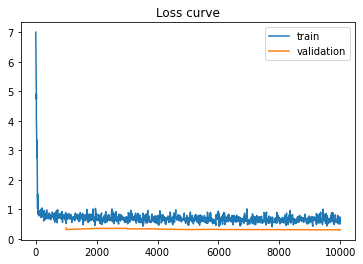

<Figure size 432x288 with 0 Axes>

In [28]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()
plt.savefig(outdir/"loss.png")

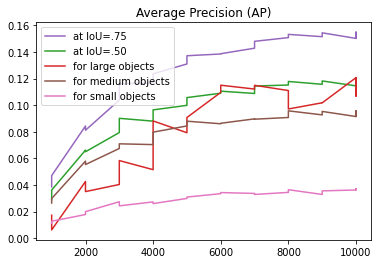

<Figure size 432x288 with 0 Axes>

In [29]:
fig, ax = plt.subplots()

mdf4 = mdf[~mdf["bbox/AP50"].isna()]
ax.plot(mdf4["iteration"], mdf4["bbox/AP75"] / 100., c="C4", label="at IoU=.75")

mdf3 = mdf[~mdf["bbox/AP75"].isna()]
ax.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., c="C2", label="at IoU=.50")

mdf5 = mdf[~mdf["bbox/APl"].isna()]
ax.plot(mdf5["iteration"], mdf5["bbox/APl"] / 100., c="C3", label="for large objects")

mdf6 = mdf[~mdf["bbox/APm"].isna()]
ax.plot(mdf6["iteration"], mdf6["bbox/APm"] / 100., c="C5", label="for medium objects")

mdf7 = mdf[~mdf["bbox/APs"].isna()]
ax.plot(mdf7["iteration"], mdf7["bbox/APs"] / 100., c="C6", label="for small objects")

ax.legend()
ax.set_title("Average Precision (AP)")
plt.show()
plt.savefig(outdir / "AP.png")

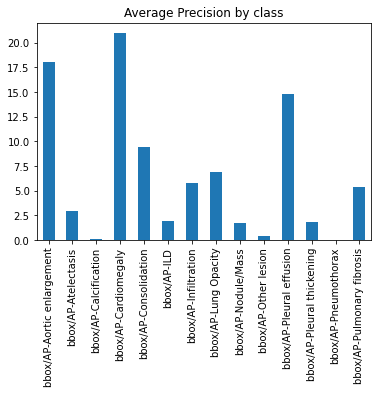

In [30]:
fig, ax = plt.subplots()
mdf_bbox_class = mdf3.iloc[-1][[f"bbox/AP-{col}" for col in thing_classes]]
mdf_bbox_class.plot(kind="bar", ax=ax)
_ = ax.set_title("Average Precision by class")

Our Evaluator calculaes AP by class, and it is easy to check which class is diffucult to train.

In my experiment, **"Calcification" seems to be the most difficult class to predict**.

<a id="vis_aug"></a>
# Visualization of augmentation by Mapper

Let's check the behavior of Mapper method. Since mapper is used inside DataLoader, we can check its behavior by constucting DataLoader and visualize the data processed by the DataLoader.

The defined Trainer class has **class method** `build_train_loader`. We can construct train_loader purely from `cfg`, without instantiating `trainer` since it's class method.

Below code is to visualize the same data 4 times. You can check that augmentation is applied and every time the image looks different.

Note that both `detectron2.data.transforms` & `albumentations` augmentations properly handles bounding box. Thus bounding box is adjusted when the image is scaled, rotated etc!

At first I was using `detectron2.data.transforms` with `MyMapper` class, it provides basic augmentations.<br/>
Then I noticed that we can use many augmentations in `albumentations`, so I implemented `AlbumentationsMapper` to support it.<br/>
How many augmentations can be used in albumentations?<br/>
You can see official github page, all [Pixel-level transforms](https://github.com/albumentations-team/albumentations#pixel-level-transforms) and [Spatial-level transforms](https://github.com/albumentations-team/albumentations#spatial-level-transforms) with "BBoxes" checked can be used. There are really many!!!

[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  GaussNoise(always_apply=False, p=0.5, var_limit=(10.0, 50.0)),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
[06/12 17:22:27 d2.data.build]: Removed 8470 images with no usable annotations. 3530 images left.
[06/12 17:22:28 d2.data.common]: Serializing 3530 elements to byte tensors

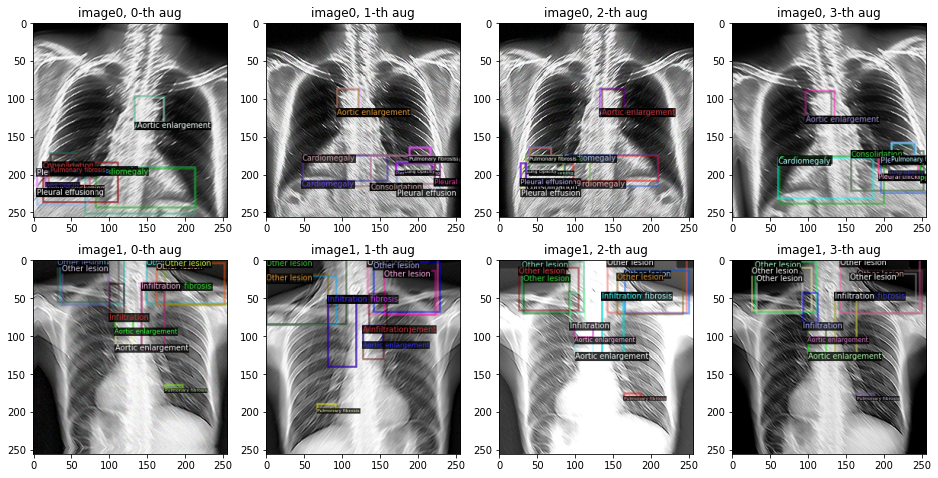

In [31]:
# Visualize data...
# import matplotlib.pyplot as plt
from detectron2.data.samplers import TrainingSampler

n_images = 2
n_aug = 4

fig, axes = plt.subplots(n_images, n_aug, figsize=(16, 8))

# Ref https://github.com/facebookresearch/detectron2/blob/22b70a8078eb09da38d0fefa130d0f537562bebc/tools/visualize_data.py#L79-L88
for i in range(n_aug):
    sampler = TrainingSampler(len(dataset_dicts), shuffle=False)
    train_vis_loader = MyTrainer.build_train_loader(
        cfg, sampler=sampler
    )  # For visualization...
    for batch in train_vis_loader:
        for j, per_image in enumerate(batch):
            ax = axes[j, i]

            img_arr = per_image["image"].cpu().numpy().transpose((1, 2, 0))
            visualizer = Visualizer(
                img_arr[:, :, ::-1], metadata=vinbigdata_metadata, scale=1.0
            )
            target_fields = per_image["instances"].get_fields()
            labels = [
                vinbigdata_metadata.thing_classes[i] for i in target_fields["gt_classes"]
            ]
            out = visualizer.overlay_instances(
                labels=labels,
                boxes=target_fields.get("gt_boxes", None),
                masks=target_fields.get("gt_masks", None),
                keypoints=target_fields.get("gt_keypoints", None),
            )
            # out = visualizer.draw_dataset_dict(per_image)

            img = out.get_image()[:, :, ::-1]
            filepath = str(outdir / f"vinbigdata_{j}_aug{i}.jpg")
            cv2.imwrite(filepath, img)
            print(f"Visualization img {img_arr.shape} saved in {filepath}")
            ax.imshow(img)
            ax.set_title(f"image{j}, {i}-th aug")
        break

In [32]:
# #TODO create model explanations
# # visualize XAI to discover what model had learnt

# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image
# import torchvision.models as models
# import torchvision

# torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

# model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model.cpu()
# print(model)

In [33]:
from torchvision import transforms

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [34]:
import torch.nn.functional as F

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cpu") #"cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

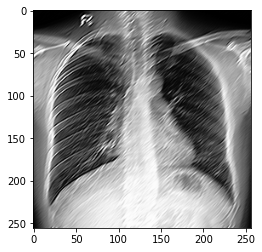

In [35]:
from PIL import Image

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image(str(imgdir) + '/test/0b2105548746dc55aa03324d07e2a2ed.png')
plt.imshow(img)

In [36]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

NameError: name 'model' is not defined

In [ ]:
# target_layer = model.backbone.body.layer3[-1]

# sampler = TrainingSampler(len(dataset_dicts), shuffle=False)
# train_vis_loader = MyTrainer.build_train_loader(cfg, sampler=sampler)
# input_tensor = None
# for batch in train_vis_loader:
#         for per_image in batch:
#             input_tensor = per_image["image"]
#             break
#         break

# print(input_tensor.shape)
# # input_tensor = input_tensor[, :, :, :]#.cpu()
# permute = [1, 2, 0]
# input_tensor = torch.transpose(input_tensor, 2,0)
# print(input_tensor.shape)

from lime import lime_image


# torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(img), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=2) # number of images that will be sent to classification function

# # input_tensor = train_vis_loader[0] #torch.ops.image.read_file(imgdir / "test" / "0a08191a658edb1327e7282045ec71cf.png")# Create an input tensor image for your model..
# # Note: input_tensor can be a batch tensor with several images!

# # Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layer=target_layer, use_cuda=False)

# # If target_category is None, the highest scoring category
# # will be used for every image in the batch.
# # target_category can also be an integer, or a list of different integers
# # for every image in the batch.
# target_category = 0

# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam)

That's all! 

I found that the competition data is not so many (15000 for all images, 4000 images after filtering "No finding" images).<br/>
It does not take long time to train (less than a day), so this competition may be a good choice for beginners who want to learn object detection!

<a id="next_step"></a>
# Next step

[📸VinBigData detectron2 prediction](https://www.kaggle.com/corochann/vinbigdata-detectron2-prediction) kernel explains how to use trained model for the prediction and submisssion for this competition.

[📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline) kernel explains how to train 2 class classifier model for the prediction and submisssion for this competition.

## Discussions
These discussions are useful to further utilize this training notebook to conduct deeper experiment.

 - [1-step training & prediction](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/219672): The 1-step pipeline which does not use any 2-class classifier approach is proposed.
 - [What anchor size & aspect ratio should be used?](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/220295): Suggests how to predict more smaller sized, high aspect ratio bonding boxes. It affects to the score a lot!!!
 - [Preferable radiologist's id in the test dataset?](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/219221): Investigation of test dataset annotation distribution.


In [ ]:
n_images = 2
n_aug = 4

fig, axes = plt.subplots(n_images, n_aug, figsize=(16, 8))

# Ref https://github.com/facebookresearch/detectron2/blob/22b70a8078eb09da38d0fefa130d0f537562bebc/tools/visualize_data.py#L79-L88
for i in range(n_aug):
    sampler = TrainingSampler(len(dataset_dicts), shuffle=False)
    train_vis_loader = MyTrainer.build_train_loader(
        cfg, sampler=sampler
    )  # For visualization...
    for batch in train_vis_loader:
        for j, per_image in enumerate(batch):
            ax = axes[j, i]

            img_arr = per_image["image"].cpu().numpy().transpose((1, 2, 0))
            visualizer = Visualizer(
                img_arr[:, :, ::-1], metadata=vinbigdata_metadata, scale=1.0
            )
            target_fields = per_image["instances"].get_fields()
            labels = [
                vinbigdata_metadata.thing_classes[i] for i in target_fields["gt_classes"]
            ]
            out = visualizer.overlay_instances(
                labels=labels,
                boxes=target_fields.get("gt_boxes", None),
                masks=target_fields.get("gt_masks", None),
                keypoints=target_fields.get("gt_keypoints", None),
            )
            # out = visualizer.draw_dataset_dict(per_image)

            img = out.get_image()[:, :, ::-1]
            filepath = str(outdir / f"vinbigdata_{j}_aug{i}.jpg")
            cv2.imwrite(filepath, img)
            print(f"Visualization img {img_arr.shape} saved in {filepath}")
            ax.imshow(img)
            ax.set_title(f"image{j}, {i}-th aug")
        break